In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import numpy.ma as ma

import gdal
import osr

import seaborn as sns
sns.set(style="whitegrid")

In [2]:
    input_params = { 
                    'INPUT_SLOPE' : r'c:\temp\zone_21_slope_5m.tif',
                    'INPUT_FLOW_LENGTH' : r'c:\temp\zone_21_flowlength_5m.tif',
                    'INPUT_FLOW_ACC' : r'c:\temp\zone_21_flowacc_5m.tif',
                    'INPUT_LS_FACTOR' : r'c:\temp\ls_faktor5m_zone_21.tif',
                    'INPUT_SOIL_CLASS' : r'c:\temp\estsoil_proc_overz_3301_21_slopebase_labeled.tif',
                    'INPUT_NOMOGRAPH_CATCHMENTS_COEFFICIENT' : 210,
                    'INPUT_MIN_ABS_BUFFER_SIZE': 3,
                    'INPUT_SLOPE_SCALE_FACTOR' : 10000,
                    'INPUT_BUFSTRIP_SCALE_FACTOR' : 50,
                    'INPUT_FLOWLEN_MAX' : 1392,
                    'INPUT_FLOWACC_MAX' : 21508,
                    'INPUT_LSFACTOR_MAX' : 100,
                    'INPUT_FLOWLEN_WEIGHT' : 3,
                    'INPUT_FLOWACC_WEIGHT' : 3,
                    'INPUT_LSFACTOR_WEIGHT' : 3,
                    'OUTPUT_BUF_SIZE' : r'c:\temp\TEMPORARY_OUTPUT_BUF_SIZE.tif',
                    'OUTPUT_SPEC_SLOPELEN' : r'c:\temp\TEMPORARY_OUTPUT_SPEC_SLOPELEN.tif'
                    }


print('reading slope tif')
slope_tif = gdal.Open(input_params['INPUT_SLOPE'])
slope_nodata = slope_tif.GetRasterBand(1).GetNoDataValue()
slope_band = slope_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"slope_nodata: {slope_nodata}")

print('reading flow length tif')
flowlen_tif = gdal.Open(input_params['INPUT_FLOW_LENGTH'])
flowlen_nodata = flowlen_tif.GetRasterBand(1).GetNoDataValue()
flowlen_band = flowlen_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"flowlen_nodata: {flowlen_nodata}")

print('reading flow accumulation tif')
flowacc_tif = gdal.Open(input_params['INPUT_FLOW_ACC'])
flowacc_nodata = flowacc_tif.GetRasterBand(1).GetNoDataValue()
flowacc_band = flowacc_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"flowacc_nodata: {flowacc_nodata}")

print('reading ls factor tif')
lsfactor_tif = gdal.Open(input_params['INPUT_LS_FACTOR'])
lsfactor_nodata = lsfactor_tif.GetRasterBand(1).GetNoDataValue()
lsfactor_band = lsfactor_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"lsfactor_nodata: {lsfactor_nodata}, but also -inf sort of")

print('reading soil class tif')
soil_tif = gdal.Open(input_params['INPUT_SOIL_CLASS'])
soil_nodata = soil_tif.GetRasterBand(1).GetNoDataValue() # but also 0
soil_band = soil_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"soil_nodata: {soil_nodata} , but also 0")


print('reading calculated buffer strip tif')
buffer_tif = gdal.Open(input_params['OUTPUT_BUF_SIZE'])
buffer_nodata = buffer_tif.GetRasterBand(1).GetNoDataValue()
buffer_band = buffer_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"buffer_nodata: {buffer_nodata}")

print('reading calculated specific slope length tif')
calc_slopelen_tif = gdal.Open(input_params['OUTPUT_SPEC_SLOPELEN'])
calc_slopelen_nodata = calc_slopelen_tif.GetRasterBand(1).GetNoDataValue() # but also 0
calc_slopelen_band = calc_slopelen_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"calc_slopelen_nodata: {calc_slopelen_nodata}")


reading slope tif
slope_nodata: -9999.0
reading flow length tif
flowlen_nodata: None
reading flow accumulation tif
flowacc_nodata: None
reading ls factor tif
lsfactor_nodata: -3.4028230607370965e+38, but also -inf sort of
reading soil class tif
soil_nodata: 0.0 , but also 0
reading calculated buffer strip tif
buffer_nodata: -1.0
reading calculated specific slope length tif
calc_slopelen_nodata: -1.0


In [3]:
nomo_df = pd.DataFrame(
{
    'slope': slope_band,
    'grass_flowlen': flowlen_band,
    'grass_flowacc': flowacc_band,
    'lsfactor': lsfactor_band,
    'soil_class': soil_band,
    'calc_slopelen': calc_slopelen_band,
    'buffer_width': buffer_band
})

nomo_df = nomo_df.loc[nomo_df['slope'] != slope_nodata]
nomo_df = nomo_df.loc[nomo_df['soil_class'] != soil_nodata]
nomo_df = nomo_df.loc[nomo_df['buffer_width'] != buffer_nodata]
nomo_df = nomo_df.loc[nomo_df['calc_slopelen'] != calc_slopelen_nodata]
nomo_df = nomo_df.loc[nomo_df['lsfactor'] != lsfactor_nodata]

In [4]:
nomo_df.head()

slope  grass_flowlen  grass_flowacc  lsfactor  soil_class  \
0  0.617881            0.0            0.0  0.105783           4   
1  0.690288            0.0            0.0  0.105783           4   
2  0.693279            0.0            0.0  0.000000           4   
3  0.858810            0.0            0.0  0.000000           4   
4  0.918346            0.0            0.0  0.000000           4   

   calc_slopelen  buffer_width  
0       7.404815           3.0  
1       7.404815           3.0  
2       0.000000           3.0  
3       0.000000           3.0  
4       0.000000           3.0

In [5]:
nomo_df.dtypes

slope            float32
grass_flowlen    float32
grass_flowacc    float64
lsfactor         float32
soil_class         int16
calc_slopelen    float32
buffer_width     float32
dtype: object

In [6]:
nomo_df.count()

slope            129716617
grass_flowlen    129716617
grass_flowacc    129716617
lsfactor         129716617
soil_class       129716617
calc_slopelen    129716617
buffer_width     129716617
dtype: int64

In [7]:
corr_df = nomo_df.corr()

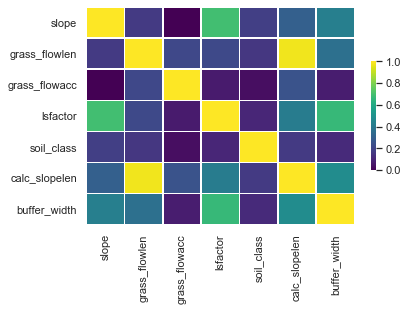

In [8]:
sns.heatmap(corr_df, cmap='viridis', vmin=0, vmax=1, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
display(corr_df.values.shape)

fl = corr_df.values.flatten()

(7, 7)

In [10]:
recorr = fl.reshape(7, 7)
pd.DataFrame(recorr)

0         1         2         3         4         5         6
0  1.000000  0.168366  0.003683  0.696127  0.187352  0.301514  0.425962
1  0.168366  1.000000  0.215465  0.219044  0.159906  0.977691  0.365267
2  0.003683  0.215465  1.000000  0.072885  0.036911  0.256995  0.078418
3  0.696127  0.219044  0.072885  1.000000  0.108456  0.414985  0.671051
4  0.187352  0.159906  0.036911  0.108456  1.000000  0.171849  0.117830
5  0.301514  0.977691  0.256995  0.414985  0.171849  1.000000  0.481100
6  0.425962  0.365267  0.078418  0.671051  0.117830  0.481100  1.000000

In [11]:
fl

array([1.        , 0.16836599, 0.0036832 , 0.69612695, 0.18735165,
       0.30151352, 0.42596187, 0.16836599, 1.        , 0.21546535,
       0.21904438, 0.15990606, 0.97769059, 0.36526665, 0.0036832 ,
       0.21546535, 1.        , 0.07288466, 0.03691137, 0.2569946 ,
       0.07841798, 0.69612695, 0.21904438, 0.07288466, 1.        ,
       0.10845602, 0.41498455, 0.67105114, 0.18735165, 0.15990606,
       0.03691137, 0.10845602, 1.        , 0.17184891, 0.11783034,
       0.30151352, 0.97769059, 0.2569946 , 0.41498455, 0.17184891,
       1.        , 0.48109996, 0.42596187, 0.36526665, 0.07841798,
       0.67105114, 0.11783034, 0.48109996, 1.        ])

In [12]:
np.concatenate([fl,fl])

array([1.        , 0.16836599, 0.0036832 , 0.69612695, 0.18735165,
       0.30151352, 0.42596187, 0.16836599, 1.        , 0.21546535,
       0.21904438, 0.15990606, 0.97769059, 0.36526665, 0.0036832 ,
       0.21546535, 1.        , 0.07288466, 0.03691137, 0.2569946 ,
       0.07841798, 0.69612695, 0.21904438, 0.07288466, 1.        ,
       0.10845602, 0.41498455, 0.67105114, 0.18735165, 0.15990606,
       0.03691137, 0.10845602, 1.        , 0.17184891, 0.11783034,
       0.30151352, 0.97769059, 0.2569946 , 0.41498455, 0.17184891,
       1.        , 0.48109996, 0.42596187, 0.36526665, 0.07841798,
       0.67105114, 0.11783034, 0.48109996, 1.        , 1.        ,
       0.16836599, 0.0036832 , 0.69612695, 0.18735165, 0.30151352,
       0.42596187, 0.16836599, 1.        , 0.21546535, 0.21904438,
       0.15990606, 0.97769059, 0.36526665, 0.0036832 , 0.21546535,
       1.        , 0.07288466, 0.03691137, 0.2569946 , 0.07841798,
       0.69612695, 0.21904438, 0.07288466, 1.        , 0.10845

In [13]:
out_records = {}
for idx, row in corr_df.iterrows():
    for col in corr_df.columns.tolist():
        # print(f"corr__{idx}__{col}: {row[col]}")
        out_records.update({f"corr__{idx}__{col}" : [row[col]]})
out_df = pd.DataFrame(out_records)
app_df = pd.DataFrame(out_records)

In [18]:

with open('corr_df_columns.txt', 'w') as fh:
    for col in out_df.columns.tolist():
        fh.write(col + '\n')

In [15]:
pd.concat([app_df, out_df], axis=0, ignore_index=True).reset_index(drop=True)

corr__slope__slope  corr__slope__grass_flowlen  corr__slope__grass_flowacc  \
0                 1.0                    0.168366                    0.003683   
1                 1.0                    0.168366                    0.003683   

   corr__slope__lsfactor  corr__slope__soil_class  corr__slope__calc_slopelen  \
0               0.696127                 0.187352                    0.301514   
1               0.696127                 0.187352                    0.301514   

   corr__slope__buffer_width  corr__grass_flowlen__slope  \
0                   0.425962                    0.168366   
1                   0.425962                    0.168366   

   corr__grass_flowlen__grass_flowlen  corr__grass_flowlen__grass_flowacc  \
0                                 1.0                            0.215465   
1                                 1.0                            0.215465   

   ...  corr__calc_slopelen__soil_class  corr__calc_slopelen__calc_slopelen  \
0  ...                         0.171849                                 1.0   
1  ...                         0.171849                                 1.0   

   corr__calc_slopelen__buffer_width  corr__buffer_width__slope  \
0                             0.4811                   0.425962   
1                             0.4811                   0.425962   

   corr__buffer_width__grass_flowlen  corr__buffer_width__grass_flowacc  \
0                           0.365267                           0.078418   
1                           0.365267                           0.078418   

   corr__buffer_width__lsfactor  corr__buffer_width__soil_class  \
0                      0.671051                         0.11783   
1                      0.671051                         0.11783   

   corr__buffer_width__calc_slopelen  corr__buffer_width__buffer_width  
0                             0.4811                               1.0  
1                             0.4811                               1.0  

[2 rows x 49 columns]

## variance measures for sensitivity testing

In [2]:
a =  { 'dest_fname' : r'c:\temp\TEMPORARY_OUTPUT_BUF_SIZE.tif',
        'dest_fname_slopelen' : r'c:\temp\TEMPORARY_OUTPUT_SPEC_SLOPELEN.tif'}

b =  {'dest_fname': r'c:\temp\QGIS_OUTPUT_BUF_SIZE.tif',
        'dest_fname_slopelen': r'c:\temp\QGIS_OUTPUT_SPEC_SLOPELEN.tif'}

In [3]:
input_params = a

print('reading calculated buffer strip tif')
buffer_tif = gdal.Open(input_params['dest_fname'])
buffer_nodata = buffer_tif.GetRasterBand(1).GetNoDataValue()
buffer_band = buffer_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"buffer_nodata: {buffer_nodata}")

del(buffer_tif)

print('reading calculated specific slope length tif')
calc_slopelen_tif = gdal.Open(input_params['dest_fname_slopelen'])
calc_slopelen_nodata = calc_slopelen_tif.GetRasterBand(1).GetNoDataValue() # but also 0
calc_slopelen_band = calc_slopelen_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"calc_slopelen_nodata: {calc_slopelen_nodata}")

del(calc_slopelen_tif)

reading calculated buffer strip tif
buffer_nodata: -1.0
reading calculated specific slope length tif
calc_slopelen_nodata: -1.0


In [4]:
input_params = b

print('reading calculated buffer strip tif')
buffer_tif = gdal.Open(input_params['dest_fname'])
buffer_nodata = buffer_tif.GetRasterBand(1).GetNoDataValue()
buffer_band_b = buffer_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"buffer_nodata: {buffer_nodata}")

del(buffer_tif)

print('reading calculated specific slope length tif')
calc_slopelen_tif = gdal.Open(input_params['dest_fname_slopelen'])
calc_slopelen_nodata = calc_slopelen_tif.GetRasterBand(1).GetNoDataValue() # but also 0
calc_slopelen_band_b = calc_slopelen_tif.GetRasterBand(1).ReadAsArray().flatten()
print(f"calc_slopelen_nodata: {calc_slopelen_nodata}")

del(calc_slopelen_tif)

reading calculated buffer strip tif
buffer_nodata: -1.0
reading calculated specific slope length tif
calc_slopelen_nodata: -1.0


In [5]:
buf_df = pd.DataFrame(
{
    'calc_slopelen_a': calc_slopelen_band,
    'buffer_width_a': buffer_band,
    'calc_slopelen_b': calc_slopelen_band_b,
    'buffer_width_b': buffer_band_b
})

In [6]:
buf_df.dtypes

calc_slopelen_a    float32
buffer_width_a     float32
calc_slopelen_b    float32
buffer_width_b     float32
dtype: object

In [7]:
buf_df = buf_df.loc[buf_df['buffer_width_a'] != buffer_nodata]
buf_df = buf_df.loc[buf_df['calc_slopelen_a'] != calc_slopelen_nodata]

buf_df = buf_df.loc[buf_df['buffer_width_b'] != buffer_nodata]
buf_df = buf_df.loc[buf_df['calc_slopelen_b'] != calc_slopelen_nodata]

buf_df = buf_df.loc[buf_df['buffer_width_a'] >= 0]
buf_df = buf_df.loc[buf_df['calc_slopelen_a'] >= 0]

buf_df = buf_df.loc[buf_df['buffer_width_b'] >= 0]
buf_df = buf_df.loc[buf_df['calc_slopelen_b'] >= 0]

In [8]:
buf_df['buffer_width_error'] = buf_df['buffer_width_a'] - buf_df['buffer_width_b']
buf_df['calc_slopelen_error'] = buf_df['calc_slopelen_a'] - buf_df['calc_slopelen_b']

In [15]:
out_records = []

dstat_buffer = buf_df['buffer_width_a'].dropna().describe(percentiles=[.05, .1, .2, .3,.4 ,.5, .6, .7, .8, .9, .95])
for idx, val in dstat_buffer.iteritems():
    out_records.append({f"dstat_buf_{idx}" : val })
    print({f"dstat_buf_{idx}" : val })
    
dstat_slopelen = buf_df['calc_slopelen_a'].dropna().describe(percentiles=[.05, .1, .2, .3,.4 ,.5, .6, .7, .8, .9, .95])
for idx, val in dstat_slopelen.iteritems():
    out_records.append({f"dstat_slopelen_{idx}" : val })
    print({f"dstat_slopelen_{idx}" : val })

dstat_buf_err = buf_df['buffer_width_error'].dropna().describe(percentiles=[.05, .1, .2, .3,.4 ,.5, .6, .7, .8, .9, .95])
for idx, val in dstat_buf_err.iteritems():
    out_records.append({f"dstat_buf_err_{idx}" : val })
    print({f"dstat_buf_err_{idx}" : val })
    
dstat_slopelen_err = buf_df['calc_slopelen_error'].dropna().describe(percentiles=[.05, .1, .2, .3,.4 ,.5, .6, .7, .8, .9, .95])
for idx, val in dstat_slopelen_err.iteritems():
    out_records.append({f"dstat_slopelen_err_{idx}" : val })
    print({f"dstat_slopelen_err_{idx}" : val })

{'dstat_buf_count': 129888144.0}
{'dstat_buf_mean': 3.106398105621338}
{'dstat_buf_std': 0.7756783366203308}
{'dstat_buf_min': 3.0}
{'dstat_buf_5%': 3.0}
{'dstat_buf_10%': 3.0}
{'dstat_buf_20%': 3.0}
{'dstat_buf_30%': 3.0}
{'dstat_buf_40%': 3.0}
{'dstat_buf_50%': 3.0}
{'dstat_buf_60%': 3.0}
{'dstat_buf_70%': 3.0}
{'dstat_buf_80%': 3.0}
{'dstat_buf_90%': 3.0}
{'dstat_buf_95%': 3.0}
{'dstat_buf_max': 85.62715148925781}
{'dstat_slopelen_count': 129888144.0}
{'dstat_slopelen_mean': 258.5577392578125}
{'dstat_slopelen_std': 355.5373840332031}
{'dstat_slopelen_min': 0.0}
{'dstat_slopelen_5%': 0.0}
{'dstat_slopelen_10%': 25.344627380371094}
{'dstat_slopelen_20%': 35.134159088134766}
{'dstat_slopelen_30%': 58.16421089172363}
{'dstat_slopelen_40%': 85.26734924316406}
{'dstat_slopelen_50%': 124.73064422607422}
{'dstat_slopelen_60%': 185.1787109375}
{'dstat_slopelen_70%': 274.49066162109375}
{'dstat_slopelen_80%': 409.7873352050783}
{'dstat_slopelen_90%': 659.2911804199221}
{'dstat_slopelen_95%':

In [14]:
out_records = []

{'dstat_buf_count': 129888144.0}
{'dstat_buf_mean': 3.106398105621338}
{'dstat_buf_std': 0.7756783366203308}
{'dstat_buf_min': 3.0}
{'dstat_buf_5%': 3.0}
{'dstat_buf_10%': 3.0}
{'dstat_buf_20%': 3.0}
{'dstat_buf_30%': 3.0}
{'dstat_buf_40%': 3.0}
{'dstat_buf_50%': 3.0}
{'dstat_buf_60%': 3.0}
{'dstat_buf_70%': 3.0}
{'dstat_buf_80%': 3.0}
{'dstat_buf_90%': 3.0}
{'dstat_buf_95%': 3.0}
{'dstat_buf_max': 85.62715148925781}


In [9]:
from spotpy.objectivefunctions import rmse, rsquared, kge, nashsutcliffe, lognashsutcliffe, correlationcoefficient,mae, pbias, covariance

In [11]:
import logging
import datetime
import sys

log_level = logging.INFO
# create logger
logger = logging.getLogger(__name__)
logger.setLevel(log_level)

formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

console = logging.StreamHandler(sys.stdout)
console.setFormatter(formatter)
logger.addHandler(console)

In [12]:
out_records = []

out_records.append({'rmse_buf' : rmse(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'rmse_slopelen' : rmse(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('rmse: buffer / calc_slopelen')
logger.info(out_records[-2:])

2020-09-21 10:39:35,934 - __main__ - INFO - rmse: buffer / calc_slopelen


INFO: <ipython-input-12-9106ca83fa10>.<module>(): rmse: buffer / calc_slopelen


2020-09-21 10:39:35,936 - __main__ - INFO - [{'rmse_buf': 0.0}, {'rmse_slopelen': 1.3043432}]


INFO: <ipython-input-12-9106ca83fa10>.<module>(): [{'rmse_buf': 0.0}, {'rmse_slopelen': 1.3043432}]


In [13]:
out_records.append({'rsquared_buf' : rsquared(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'rsquared_slopelen' : rsquared(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('rsquared: buffer / calc_slopelen')
logger.info(out_records[-2:])

out_records.append({'kge_buf' : kge(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'kge_slopelen' : kge(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('kge: buffer / calc_slopelen')
logger.info(out_records[-2:])

out_records.append({'nashsutcliffe_buf' : nashsutcliffe(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'nashsutcliffe_slopelen' : nashsutcliffe(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('nashsutcliffe: buffer / calc_slopelen')
logger.info(out_records[-2:])

# out_records.append({'lognashsutcliffe_buf' : lognashsutcliffe(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
# out_records.append({'lognashsutcliffe_slopelen' : lognashsutcliffe(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
# logger.info('lognashsutcliffe: buffer / calc_slopelen')
# logger.info(out_records[-2:])

out_records.append({'correlationcoefficient_buf' : correlationcoefficient(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'correlationcoefficient_slopelen' : correlationcoefficient(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('correlationcoefficient: buffer / calc_slopelen')
logger.info(out_records[-2:])

out_records.append({'mae_buf' : mae(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'mae_slopelen' : mae(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('mae: buffer / calc_slopelen')
logger.info(out_records[-2:])

out_records.append({'pbias_buf' : pbias(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'pbias_slopelen' : pbias(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('pbias: buffer / calc_slopelen')
logger.info(out_records[-2:])

out_records.append({'covariance_buf' : covariance(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'covariance_slopelen' : covariance(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('covariance: buffer / calc_slopelen')
logger.info(out_records[-2:])




2020-09-21 10:41:05,478 - __main__ - INFO - rsquared: buffer / calc_slopelen


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): rsquared: buffer / calc_slopelen


2020-09-21 10:41:05,481 - __main__ - INFO - [{'rsquared_buf': 1.0}, {'rsquared_slopelen': 0.9999879718263154}]


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): [{'rsquared_buf': 1.0}, {'rsquared_slopelen': 0.9999879718263154}]


2020-09-21 10:41:17,756 - __main__ - INFO - kge: buffer / calc_slopelen


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): kge: buffer / calc_slopelen


2020-09-21 10:41:17,758 - __main__ - INFO - [{'kge_buf': 1.0}, {'kge_slopelen': 0.9984885847698713}]


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): [{'kge_buf': 1.0}, {'kge_slopelen': 0.9984885847698713}]


2020-09-21 10:41:22,355 - __main__ - INFO - nashsutcliffe: buffer / calc_slopelen


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): nashsutcliffe: buffer / calc_slopelen


2020-09-21 10:41:22,358 - __main__ - INFO - [{'nashsutcliffe_buf': 1.0}, {'nashsutcliffe_slopelen': 0.9999865410063649}]


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): [{'nashsutcliffe_buf': 1.0}, {'nashsutcliffe_slopelen': 0.9999865410063649}]


2020-09-21 10:41:27,004 - __main__ - INFO - correlationcoefficient: buffer / calc_slopelen


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): correlationcoefficient: buffer / calc_slopelen


2020-09-21 10:41:27,006 - __main__ - INFO - [{'correlationcoefficient_buf': 1.0}, {'correlationcoefficient_slopelen': 0.9999939858950729}]


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): [{'correlationcoefficient_buf': 1.0}, {'correlationcoefficient_slopelen': 0.9999939858950729}]


2020-09-21 10:41:28,663 - __main__ - INFO - mae: buffer / calc_slopelen


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): mae: buffer / calc_slopelen


2020-09-21 10:41:28,666 - __main__ - INFO - [{'mae_buf': 0.0}, {'mae_slopelen': 0.34601295}]


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): [{'mae_buf': 0.0}, {'mae_slopelen': 0.34601295}]


2020-09-21 10:41:31,132 - __main__ - INFO - pbias: buffer / calc_slopelen


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): pbias: buffer / calc_slopelen


2020-09-21 10:41:31,133 - __main__ - INFO - [{'pbias_buf': 0.0}, {'pbias_slopelen': 0.13382425481381105}]


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): [{'pbias_buf': 0.0}, {'pbias_slopelen': 0.13382425481381105}]


2020-09-21 10:41:33,508 - __main__ - INFO - covariance: buffer / calc_slopelen


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): covariance: buffer / calc_slopelen


2020-09-21 10:41:33,509 - __main__ - INFO - [{'covariance_buf': 0.6016784}, {'covariance_slopelen': 126317.664}]


INFO: <ipython-input-13-ca2871a3f9fe>.<module>(): [{'covariance_buf': 0.6016784}, {'covariance_slopelen': 126317.664}]


In [14]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, mean_squared_log_error

out_records.append({'r2_score_buf' : r2_score(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'r2_score_slopelen' : r2_score(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('r2_score: buffer / calc_slopelen')
logger.info(out_records[-2:])

out_records.append({'sk_mean_absolute_error_buf' : mean_absolute_error(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'sk_mean_absolute_error_slopelen' : mean_absolute_error(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('sklearn mean_absolute_error: buffer / calc_slopelen')
logger.info(out_records[-2:])

out_records.append({'mse_buf' : mean_squared_error(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'mse_slopelen' : mean_squared_error(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('mean_squared_error: buffer / calc_slopelen')
logger.info(out_records[-2:])

# out_records.append({'mean_squared_log_error_buf' : mean_squared_log_error(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
# out_records.append({'mean_squared_log_error_slopelen' : mean_squared_log_error(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
# logger.info('mean_squared_log_error: buffer / calc_slopelen')
# logger.info(out_records[-2:])

out_records.append({'explained_variance_score_buf' : explained_variance_score(buf_df['buffer_width_a'], buf_df['buffer_width_b']) })
out_records.append({'explained_variance_score_slopelen' : explained_variance_score(buf_df['calc_slopelen_a'], buf_df['calc_slopelen_b']) })
logger.info('explained_variance_score: buffer / calc_slopelen')
logger.info(out_records[-2:])

out_records.append({'mad_buf' : buf_df['buffer_width_error'].mad() })
out_records.append({'mad_slopelen' : buf_df['calc_slopelen_error'].mad() })
logger.info('mad: buffer / calc_slopelen')
logger.info(out_records[-2:])

2020-09-21 10:42:01,095 - __main__ - INFO - r2_score: buffer / calc_slopelen


INFO: <ipython-input-14-fad209eb4af1>.<module>(): r2_score: buffer / calc_slopelen


2020-09-21 10:42:01,097 - __main__ - INFO - [{'r2_score_buf': 1.0}, {'r2_score_slopelen': 0.9999865409627292}]


INFO: <ipython-input-14-fad209eb4af1>.<module>(): [{'r2_score_buf': 1.0}, {'r2_score_slopelen': 0.9999865409627292}]


2020-09-21 10:42:02,623 - __main__ - INFO - sklearn mean_absolute_error: buffer / calc_slopelen


INFO: <ipython-input-14-fad209eb4af1>.<module>(): sklearn mean_absolute_error: buffer / calc_slopelen


2020-09-21 10:42:02,625 - __main__ - INFO - [{'sk_mean_absolute_error_buf': 0.0}, {'sk_mean_absolute_error_slopelen': 0.34601295}]


INFO: <ipython-input-14-fad209eb4af1>.<module>(): [{'sk_mean_absolute_error_buf': 0.0}, {'sk_mean_absolute_error_slopelen': 0.34601295}]


2020-09-21 10:42:04,159 - __main__ - INFO - mean_squared_error: buffer / calc_slopelen


INFO: <ipython-input-14-fad209eb4af1>.<module>(): mean_squared_error: buffer / calc_slopelen


2020-09-21 10:42:04,160 - __main__ - INFO - [{'mse_buf': 0.0}, {'mse_slopelen': 1.7013111}]


INFO: <ipython-input-14-fad209eb4af1>.<module>(): [{'mse_buf': 0.0}, {'mse_slopelen': 1.7013111}]


2020-09-21 10:42:07,812 - __main__ - INFO - explained_variance_score: buffer / calc_slopelen


INFO: <ipython-input-14-fad209eb4af1>.<module>(): explained_variance_score: buffer / calc_slopelen


2020-09-21 10:42:07,813 - __main__ - INFO - [{'explained_variance_score_buf': 1.0}, {'explained_variance_score_slopelen': 0.9999874830245972}]


INFO: <ipython-input-14-fad209eb4af1>.<module>(): [{'explained_variance_score_buf': 1.0}, {'explained_variance_score_slopelen': 0.9999874830245972}]


2020-09-21 10:42:20,014 - __main__ - INFO - mad: buffer / calc_slopelen


INFO: <ipython-input-14-fad209eb4af1>.<module>(): mad: buffer / calc_slopelen


2020-09-21 10:42:20,016 - __main__ - INFO - [{'mad_buf': 0.0}, {'mad_slopelen': 0.64319336}]


INFO: <ipython-input-14-fad209eb4af1>.<module>(): [{'mad_buf': 0.0}, {'mad_slopelen': 0.64319336}]


In [15]:
len(out_records)

26

In [24]:
key_list = []
value_list = []

for d in out_records:
    k = list(d.keys())[0]
    v = d[k]
    key_list.append(k)
    value_list.append(v)
    print(f"{k}: {v}")

with open('error_metrics_columns.txt', 'w') as fh:
    for col in key_list:
        fh.write(col + '\n')
        
err_arr = np.array(value_list)

print(err_arr)

rmse_buf: 0.0
rmse_slopelen: 1.3043432235717773
rsquared_buf: 1.0
rsquared_slopelen: 0.9999879718263154
kge_buf: 1.0
kge_slopelen: 0.9984885847698713
nashsutcliffe_buf: 1.0
nashsutcliffe_slopelen: 0.9999865410063649
correlationcoefficient_buf: 1.0
correlationcoefficient_slopelen: 0.9999939858950729
mae_buf: 0.0
mae_slopelen: 0.3460129499435425
pbias_buf: 0.0
pbias_slopelen: 0.13382425481381105
covariance_buf: 0.6016783714294434
covariance_slopelen: 126317.6640625
r2_score_buf: 1.0
r2_score_slopelen: 0.9999865409627292
sk_mean_absolute_error_buf: 0.0
sk_mean_absolute_error_slopelen: 0.3460129499435425
mse_buf: 0.0
mse_slopelen: 1.7013111114501953
explained_variance_score_buf: 1.0
explained_variance_score_slopelen: 0.9999874830245972
mad_buf: 0.0
mad_slopelen: 0.6431933641433716
[0.00000000e+00 1.30434322e+00 1.00000000e+00 9.99987972e-01
 1.00000000e+00 9.98488585e-01 1.00000000e+00 9.99986541e-01
 1.00000000e+00 9.99993986e-01 0.00000000e+00 3.46012950e-01
 0.00000000e+00 1.33824255e-0

In [18]:
buf_df.loc[buf_df['calc_slopelen_a'] < 3].count()

calc_slopelen_a        9165743
buffer_width_a         9165743
calc_slopelen_b        9165743
buffer_width_b         9165743
buffer_width_error     9165743
calc_slopelen_error    9165743
dtype: int64

In [19]:
buf_df.loc[buf_df['calc_slopelen_b'] < 3].count()

calc_slopelen_a        0
buffer_width_a         0
calc_slopelen_b        0
buffer_width_b         0
buffer_width_error     0
calc_slopelen_error    0
dtype: int64

## sensit spotpy

In [2]:
from osgeo import gdal, osr

import sys
import os

import numpy as np
import numpy.ma as ma


def getDataParams():
        
        # soil types
        k_coarse_sand=1.0
        nom_a_k7=58.0

        k_fine_sand=0.80
        nom_a_k6=52.0

        k_loamy_sand=0.61
        nom_a_k5=45.0

        k_sandy_loam=0.53
        nom_a_k4=41.0

        k_sandy_clay_sandy_loam=0.43
        nom_a_k3=34.0

        k_clay_loam_sandy_clay=0.33
        nom_a_k2=29.0

        k_loam=0.21
        nom_a_k7=24.0

        soil_dict = {
            "coarse_sand" : {"k":1.0,
                             "alpha":58.0
                            },
            "fine_sand" : {"k":0.80,
                           "alpha":52.0
                          },
            "loamy_sand" : {"k":0.61,
                            "alpha":45.0
                           },
            "sandy_loam" : {"k":0.53,
                            "alpha":41.0
                           },
            "sandy_clay_sandy_loam" : {"k":0.43,
                                       "alpha":34.0
                                      },
            "clay_loam_sandy_clay" : {"k":0.33,
                                      "alpha":29.0
                                     },
            "loam" : {"k":0.21,
                      "alpha":24.0}
        }

        a9_limes=45.0
        nom_a_i9=180.0-117

        a8_limes=35.0
        nom_a_i8=180.0-122

        # slope ranges
        a7=25.0
        i7=0.47
        nom_a_i7=180.0-128

        a6=15.0
        i6=0.27
        nom_a_i6=180.0-135

        a5=10.0
        i5=0.1
        nom_a_i5=180.0-141

        a4=5.0
        i4=0.08
        nom_a_i4=180.0-150

        a3=2.0
        i3=0.035
        nom_a_i3=180.0-160

        a2=1.0
        i2=0.015
        nom_a_i2=180.0-165

        a1=0.5
        i1=0.01
        nom_a_i1=180.0-170

        x_sl = np.array([a1, a2, a3, a4, a5, a6, a7, a8_limes, a9_limes])
        y_sl = np.array([nom_a_i1, nom_a_i2, nom_a_i3, nom_a_i4, nom_a_i5, nom_a_i6, nom_a_i7, nom_a_i8, nom_a_i9])
        pred_sl_fun = np.polyfit(x_sl, y_sl, 5)
        
        pred_sl = np.poly1d(pred_sl_fun)

        soil_classes_list_arr = np.array([soil_dict[k]['alpha'] for k in soil_dict.keys()])
        
        return {'pred_sl': pred_sl, 'soil_classes_list_arr': soil_classes_list_arr}


def degr_to_perc_slope(degrees):
    return (np.tan(np.radians(degrees)))*100


def pre_vect_slope_angle_rel_y_val(slope_angle_degr, slopelen_m, slope_scale_factor):
    slope_rel=slopelen_m/slope_scale_factor
    alpha = getDataParams()['pred_sl'](slope_angle_degr)
    y = slope_rel * (np.tan(np.radians(alpha)))
    return y


def pre_vect_select_angle_for_soil_class(soil_class):
    return np.take(getDataParams()['soil_classes_list_arr'], soil_class-1)


def pre_vect_soiltype_rel_x_val(soil_class, y, buffer_strip_scale):
    alpha=pre_vect_select_angle_for_soil_class(soil_class)
    beta = 90-alpha
    x = y * (np.tan(np.radians(beta)))
    return x * buffer_strip_scale


def pre_vect_nomo_simple(slopelen_m, slope_angle_degr, soil_class, slope_scale_factor, buffer_strip_scale):
    nomo_vals = pre_vect_soiltype_rel_x_val(soil_class, pre_vect_slope_angle_rel_y_val(slope_angle_degr, slopelen_m, slope_scale_factor), buffer_strip_scale )
    return nomo_vals


def nomograph(slope_raster_in,
                    flowlen_raster_in,
                    flowacc_raster_in,
                    lsfactor_raster_in,
                    soil_class_raster_in,
                    nomo_catch_coeff,
                    min_abs_buffer_size,
                    slope_scale_factor,
                    buffer_strip_scale,
                    flowlen_max_value,
                    flowacc_max_value,
                    lsfactor_max_value,
                    flowlen_weight,
                    flowacc_weight,
                    lsfactor_weight,
                    dest_fname,
                    dest_fname_slopelen ):



    print('reading slope tif')
    slope_tif = gdal.Open(slope_raster_in)
    slope_nodata = slope_tif.GetRasterBand(1).GetNoDataValue()
    slope_band = slope_tif.GetRasterBand(1).ReadAsArray()
    
    geotrans = slope_tif.GetGeoTransform()
    
    height = slope_band.shape[0]
    width = slope_band.shape[1]

    print('reading flow length tif')
    flowlen_tif = gdal.Open(flowlen_raster_in)
    flowlen_nodata = flowlen_tif.GetRasterBand(1).GetNoDataValue()
    flowlen_band = flowlen_tif.GetRasterBand(1).ReadAsArray()

    print('reading flow accumulation tif')
    flowacc_tif = gdal.Open(flowacc_raster_in)
    flowacc_nodata = flowacc_tif.GetRasterBand(1).GetNoDataValue()
    flowacc_band = flowacc_tif.GetRasterBand(1).ReadAsArray()

    print('reading ls factor tif')
    lsfactor_tif = gdal.Open(lsfactor_raster_in)
    lsfactor_nodata = lsfactor_tif.GetRasterBand(1).GetNoDataValue()
    lsfactor_band = lsfactor_tif.GetRasterBand(1).ReadAsArray()

    print('reading soil class tif')
    soil_tif = gdal.Open(soil_class_raster_in)
    soil_nodata = soil_tif.GetRasterBand(1).GetNoDataValue() # but also 0
    soil_band = soil_tif.GetRasterBand(1).ReadAsArray()

    slope_band_x = slope_band

    print('normalising flow length raster into 0-100 (min=0, max=1391.5403)')
    flowlen_band_x = ( flowlen_band - 0 ) / ( flowlen_max_value - 0 ) * 100

    print('normalising flow accumulation raster into 0-100 (min=0, max=21508)')
    flowacc_band_x = ( flowacc_band - 0 ) / ( flowacc_max_value - 0 ) * 100
    
    print('normalising LS factor raster into 0-100 (min=0, max=100)')
    lsfactor_band_x = ( lsfactor_band - 0 ) / ( lsfactor_max_value - 0 ) * 100

    # soil_band_x = ma.filled(soil_band, 0)
    soil_band_x = soil_band

    slope_nan = np.count_nonzero(np.isnan(slope_band_x))
    if slope_nan > 0:
        print('slope tif has NaN values (e.g. infinite nodata or null), might cause problem')
        
    flowlen_nan = np.count_nonzero(np.isnan(flowlen_band_x))
    if flowlen_nan > 0:
        print('slope length tif has NaN values (e.g. infinite nodata or null), might cause problem')
    
    flowacc_nan = np.count_nonzero(np.isnan(flowacc_band_x))
    if flowacc_nan > 0:
        print('slope accumulation tif has NaN values (e.g. infinite nodata or null), might cause problem')
    
    lsfactor_nan = np.count_nonzero(np.isnan(lsfactor_band_x))
    if lsfactor_nan > 0:
        print('lsfactor tif has NaN values (e.g. infinite nodata or null), might cause problem')

    soil_nan =  np.count_nonzero(np.isnan(soil_band_x))
    if soil_nan > 0:
        print('soil tif has NaN values (e.g. infinite nodata or null), might cause problem')
    

    all_weights = flowlen_weight + flowacc_weight + lsfactor_weight
    print(f"weighing rasters flow_length ({flowlen_weight}), flow_acc ({flowacc_weight}) and ls_factor ({lsfactor_weight}) into 1-100 ({all_weights})")

    slope_len_band_x = ( (flowlen_band_x * flowlen_weight) + (flowacc_band_x * flowacc_weight) + (lsfactor_band_x * lsfactor_weight) ) / all_weights * nomo_catch_coeff
    slope_len_band_x_np = np.where(slope_len_band_x < 0, 0, slope_len_band_x)

    print('starting nomograph calculations')
    if min_abs_buffer_size is None:
        min_abs_buffer_size = 0
    elif min_abs_buffer_size < 0:
        min_abs_buffer_size = 0
    buf_recom_val = np.where(soil_band_x==0, np.nan, pre_vect_nomo_simple(slope_len_band_x_np, slope_band_x, soil_band_x, slope_scale_factor, buffer_strip_scale))
    buf_recom_val_np = np.where(buf_recom_val < min_abs_buffer_size, min_abs_buffer_size, buf_recom_val)

    print('writing final output raster for buffer strip size')
    buf_recom_val_x = np.nan_to_num(buf_recom_val_np, copy=False, nan=-1)

    driver = gdal.GetDriverByName("GTIFF")

    dataset = driver.Create(
            dest_fname,
            width,
            height,
            1,
            gdal.GDT_Float32,
            options = [ 'COMPRESS=DEFLATE' ]
            )
    
    dataset.SetGeoTransform(geotrans)

    out_srs = osr.SpatialReference()
    out_srs.ImportFromWkt(slope_tif.GetProjectionRef())

    dataset.SetProjection(out_srs.ExportToWkt())
    dataset.GetRasterBand(1).WriteArray(buf_recom_val_x.astype(np.float32))  # add ".T" if it's inverted.
    
    dataset.GetRasterBand(1).SetNoDataValue(-1.0)
    dataset.GetRasterBand(1).FlushCache()

    dataset = None
    
    print('writing final output raster for weighted specific slope length')

    slope_len_band_x_out = np.nan_to_num(slope_len_band_x_np, copy=False, nan=-1)

    dataset2 = driver.Create(
            dest_fname_slopelen,
            width,
            height,
            1,
            gdal.GDT_Float32,
            options = [ 'COMPRESS=DEFLATE' ]
            )
    dataset2.SetGeoTransform(geotrans)

    dataset2.SetProjection(out_srs.ExportToWkt())
    dataset2.GetRasterBand(1).WriteArray(slope_len_band_x_out.astype(np.float32))  # add ".T" if it's inverted.
    
    dataset2.GetRasterBand(1).SetNoDataValue(-1.0)
    dataset2.GetRasterBand(1).FlushCache()

    dataset2 = None

    print('script finished')

    # Return the results of the algorithm, all be included in the returned
    # dictionary, with keys matching the feature corresponding parameter
    # or output names.
    return {'OUTPUT_BUF_SIZE': dest_fname, 'OUTPUT_SPEC_SLOPELEN': dest_fname_slopelen}


def params_to_nomograph(params_dict):
    
    INPUT_SLOPE = params_dict['INPUT_SLOPE']
    INPUT_FLOW_LENGTH = params_dict['INPUT_FLOW_LENGTH']
    INPUT_FLOW_ACC = params_dict['INPUT_FLOW_ACC']
    INPUT_LS_FACTOR = params_dict['INPUT_LS_FACTOR']
    INPUT_SOIL_CLASS = params_dict['INPUT_SOIL_CLASS']
    
    INPUT_NOMOGRAPH_CATCHMENTS_COEFFICIENT = params_dict['INPUT_NOMOGRAPH_CATCHMENTS_COEFFICIENT']
    INPUT_MIN_ABS_BUFFER_SIZE = params_dict['INPUT_MIN_ABS_BUFFER_SIZE']
    INPUT_SLOPE_SCALE_FACTOR = params_dict['INPUT_SLOPE_SCALE_FACTOR']
    INPUT_BUFSTRIP_SCALE_FACTOR = params_dict['INPUT_BUFSTRIP_SCALE_FACTOR']

    INPUT_FLOWLEN_MAX = params_dict['INPUT_FLOWLEN_MAX']
    INPUT_FLOWACC_MAX = params_dict['INPUT_FLOWACC_MAX']
    INPUT_LSFACTOR_MAX = params_dict['INPUT_LSFACTOR_MAX']

    INPUT_FLOWLEN_WEIGHT = params_dict['INPUT_FLOWLEN_WEIGHT']
    INPUT_FLOWACC_WEIGHT = params_dict['INPUT_FLOWACC_WEIGHT']
    INPUT_LSFACTOR_WEIGHT = params_dict['INPUT_LSFACTOR_WEIGHT']
    
    OUTPUT_BUF_SIZE = params_dict['OUTPUT_BUF_SIZE']
    OUTPUT_SPEC_SLOPELEN = params_dict['OUTPUT_SPEC_SLOPELEN']

    return nomograph(slope_raster_in=INPUT_SLOPE,
                    flowlen_raster_in = INPUT_FLOW_LENGTH,
                    flowacc_raster_in = INPUT_FLOW_ACC,
                    lsfactor_raster_in = INPUT_LS_FACTOR,
                    soil_class_raster_in = INPUT_SOIL_CLASS,
                    nomo_catch_coeff = INPUT_NOMOGRAPH_CATCHMENTS_COEFFICIENT,
                    min_abs_buffer_size = INPUT_MIN_ABS_BUFFER_SIZE,
                    slope_scale_factor = INPUT_SLOPE_SCALE_FACTOR,
                    buffer_strip_scale = INPUT_BUFSTRIP_SCALE_FACTOR,
                    flowlen_max_value = INPUT_FLOWLEN_MAX,
                    flowacc_max_value = INPUT_FLOWACC_MAX,
                    lsfactor_max_value = INPUT_LSFACTOR_MAX,
                    flowlen_weight = INPUT_FLOWLEN_WEIGHT,
                    flowacc_weight = INPUT_FLOWACC_WEIGHT,
                    lsfactor_weight = INPUT_LSFACTOR_WEIGHT,
                    dest_fname = OUTPUT_BUF_SIZE,
                    dest_fname_slopelen = OUTPUT_SPEC_SLOPELEN)


In [3]:
import spotpy

class nomo_spotpy_setup(object):
    def __init__(self, observed_data, param_defs, parallel="seq", temp_dir=None):
        self.observed_data = observed_data
        
        self.params = []
        for i in range(len(param_defs)):
            self.params.append(
                spotpy.parameter.Uniform(
                    name=param_defs[i][0],
                    low=param_defs[i][1],
                    high=param_defs[i][2],
                    optguess=param_defs[i][3] ))
    
        self.temp_dir = temp_dir
        self.parallel = parallel

        if self.parallel == "seq":
            pass

        if self.parallel == "mpi":

            from mpi4py import MPI

            comm = MPI.COMM_WORLD
            self.mpi_size = comm.Get_size()
            self.mpi_rank = comm.Get_rank()
    
    def parameters(self):
        return spotpy.parameter.generate(self.params)
    
    
    # provide the available observed data
    def evaluation(self):
        # observations = [self.observed_data]
        print('reading observed baseline calculated buffer strip tif')
        buffer_tif = gdal.Open(self.observed_data['dest_fname'])
        buffer_nodata = buffer_tif.GetRasterBand(1).GetNoDataValue()
        buffer_band_b = buffer_tif.GetRasterBand(1).ReadAsArray().flatten()
        print(f"buffer_nodata: {buffer_nodata}")

        del(buffer_tif)

        # print('reading observed baseline calculated specific slope length tif')
        # calc_slopelen_tif = gdal.Open(self.observed_data['dest_fname_slopelen'])
        # calc_slopelen_nodata = calc_slopelen_tif.GetRasterBand(1).GetNoDataValue() # but also 0
        # calc_slopelen_band_b = calc_slopelen_tif.GetRasterBand(1).ReadAsArray().flatten()
        # print(f"calc_slopelen_nodata: {calc_slopelen_nodata}")
        
        # result_values_for_tracking = collect_result_values_for_tracking(nomo_out, input_params)
        
        return buffer_band_b # self.observed_data


    # Simulation function must not return values besides for which evaluation values/observed data are available
    def simulation(self, parameters):
        
        print(f"this iteration's parameters:")
        print(parameters)
        print(len(parameters))
        print(parameters[0])
        
        # do stuff
        input_params = { 
                'INPUT_SLOPE' : r'c:\temp\zone_21_slope_5m.tif',
                'INPUT_FLOW_LENGTH' : r'c:\temp\zone_21_flowlength_5m.tif',
                'INPUT_FLOW_ACC' : r'c:\temp\zone_21_flowacc_5m.tif',
                'INPUT_LS_FACTOR' : r'c:\temp\ls_faktor5m_zone_21.tif',
                'INPUT_SOIL_CLASS' : r'c:\temp\estsoil_proc_overz_3301_21_slopebase_labeled.tif',
                'INPUT_NOMOGRAPH_CATCHMENTS_COEFFICIENT' : 210,
                'INPUT_MIN_ABS_BUFFER_SIZE': 3,
                'INPUT_SLOPE_SCALE_FACTOR' : 10000,
                'INPUT_BUFSTRIP_SCALE_FACTOR' : 50,
                'INPUT_FLOWLEN_MAX' : 1392,
                'INPUT_FLOWACC_MAX' : 21508,
                'INPUT_LSFACTOR_MAX' : 100,
                'INPUT_FLOWLEN_WEIGHT' : parameters[0],
                'INPUT_FLOWACC_WEIGHT' : parameters[1],
                'INPUT_LSFACTOR_WEIGHT' : parameters[2],
                'OUTPUT_BUF_SIZE' : r'c:\temp\TEMPORARY_OUTPUT_BUF_SIZE_spotpy_x.tif',
                'OUTPUT_SPEC_SLOPELEN' : r'c:\temp\TEMPORARY_OUTPUT_SPEC_SLOPELEN_spotpy_x.tif'
                }
        
        print(input_params)
        nomo_out = params_to_nomograph(input_params)
        
        # result_values_for_tracking = collect_result_values_for_tracking(nomo_out, input_params)
        print('reading observed baseline calculated buffer strip tif')
        buffer_tif = gdal.Open(nomo_out['OUTPUT_BUF_SIZE'])
        buffer_nodata = buffer_tif.GetRasterBand(1).GetNoDataValue()
        buffer_band_b = buffer_tif.GetRasterBand(1).ReadAsArray().flatten()
        print(f"buffer_nodata: {buffer_nodata}")
        
        del(buffer_tif)
        
        try:
            os.remove(nomo_out['OUTPUT_BUF_SIZE'])
            os.remove(nomo_out['OUTPUT_SPEC_SLOPELEN'])
        except:
            pass
        
        return buffer_band_b # result_values_for_tracking
    
    
    # if we want to minimize our function, we can select a negative objective function
    def objectivefunction(self, simulation, evaluation):
        print("simulation")
        print(len(simulation))
        print("evaluation")
        print(len(evaluation))

        objectivefunction = spotpy.objectivefunctions.rsquared(evaluation,simulation)      
        return objectivefunction
    

In [ ]:
repetitions=20

parallel = 'seq'

dbformat = "csv"

observed_data =  { 'dest_fname' : r'c:\temp\QGIS_OUTPUT_BUF_SIZE.tif',
        'dest_fname_slopelen' : r'c:\temp\QGIS_OUTPUT_SPEC_SLOPELEN.tif'}

param_defs = [
                ('FLOWLENWEIGHT',1,10,3),
                ('FLOWACCWEIGHT',1,10,3),
                ('LSFACTORWEIGHT',1,10,3)
            ]

get_ready = nomo_spotpy_setup(observed_data, param_defs, parallel="seq", temp_dir=r'c:\temp')

fast_sampler = spotpy.algorithms.fast(get_ready, parallel=parallel, dbname='demo_nomo_fast', dbformat=dbformat, save_sim=False)

fast_sampler.sample(repetitions)

In [8]:
results = fast_sampler.getdata()

In [9]:
results

array([(1.    , 7.797, 7.78 , 7.797, 1.),
       (0.995 , 7.797, 9.61 , 9.625, 1.),
       (0.9985, 7.797, 7.047, 7.06 , 1.),
       (0.963 , 7.797, 4.48 , 4.496, 1.),
       (0.8237, 7.797, 1.914, 1.934, 1.),
       (0.879 , 7.797, 2.65 , 2.67 , 1.),
       (0.98  , 7.797, 5.22 , 5.23 , 1.),
       (1.    , 1.941, 1.939, 1.958, 1.),
       (0.977 , 4.51 , 1.939, 4.52 , 1.),
       (0.9604, 7.086, 1.939, 7.082, 1.),
       (0.951 , 9.66 , 1.939, 9.65 , 1.),
       (0.9575, 7.773, 1.939, 7.77 , 1.),
       (0.9717, 5.203, 1.939, 5.207, 1.),
       (0.9956, 2.63 , 1.939, 2.645, 1.),
       (1.    , 4.42 , 4.414, 4.43 , 1.),
       (0.9536, 1.85 , 1.848, 4.43 , 1.),
       (0.985 , 2.723, 2.719, 4.43 , 1.),
       (0.998 , 5.293, 5.285, 4.43 , 1.),
       (0.9844, 7.863, 7.848, 4.43 , 1.),
       (0.9746, 9.56 , 9.55 , 4.43 , 1.),
       (0.9897, 6.992, 6.98 , 4.43 , 1.)],
      dtype=[('like1', '<f8'), ('parFLOWLENWEIGHT', '<f8'), ('parFLOWACCWEIGHT', '<f8'), ('parLSFACTORWEIGHT', '<f8')

('Number of model runs:', 21)
('Number of parameters:', 3)
('m =', 0)
('Omega =', array([0., 1., 1.]))
Parameter First Total
{'S1': [None, None, None], 'ST': [None, None, None]}
[0 1 2 3 4 5 6]
{'S1': [0.0960505612787041, None, None], 'ST': [1.0, None, None]}
FLOWLENWEIGHT 0.096051 1.000000
[ 7  8  9 10 11 12 13]
{'S1': [0.0960505612787041, 0.02051484817030568, None], 'ST': [1.0, 1.0, None]}
FLOWACCWEIGHT 0.020515 1.000000
[14 15 16 17 18 19 20]
{'S1': [0.0960505612787041, 0.02051484817030568, 0.7631868461389796], 'ST': [1.0, 1.0, 1.0]}
LSFACTORWEIGHT 0.763187 1.000000


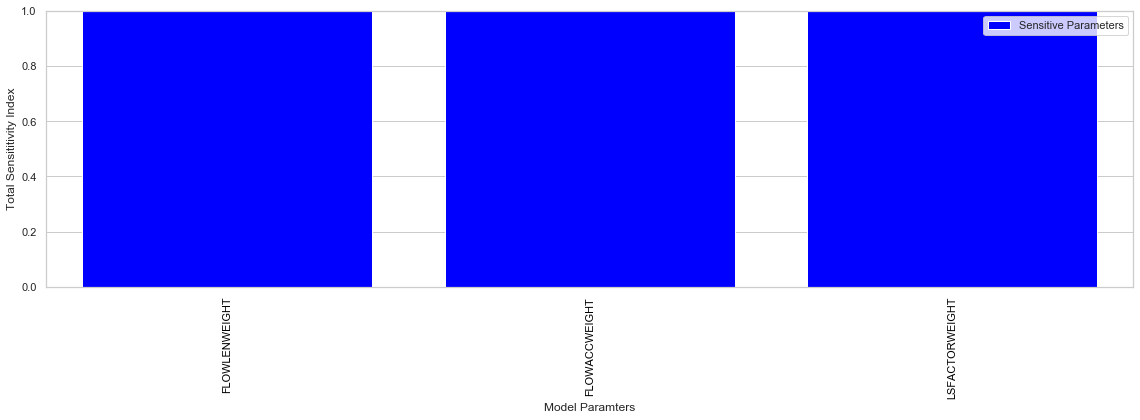

In [11]:
spotpy.analyser.plot_fast_sensitivity(results,number_of_sensitiv_pars=2)

reading observed baseline calculated buffer strip tif
buffer_nodata: -1.0


IndexError: index 0 is out of bounds for axis 0 with size 0

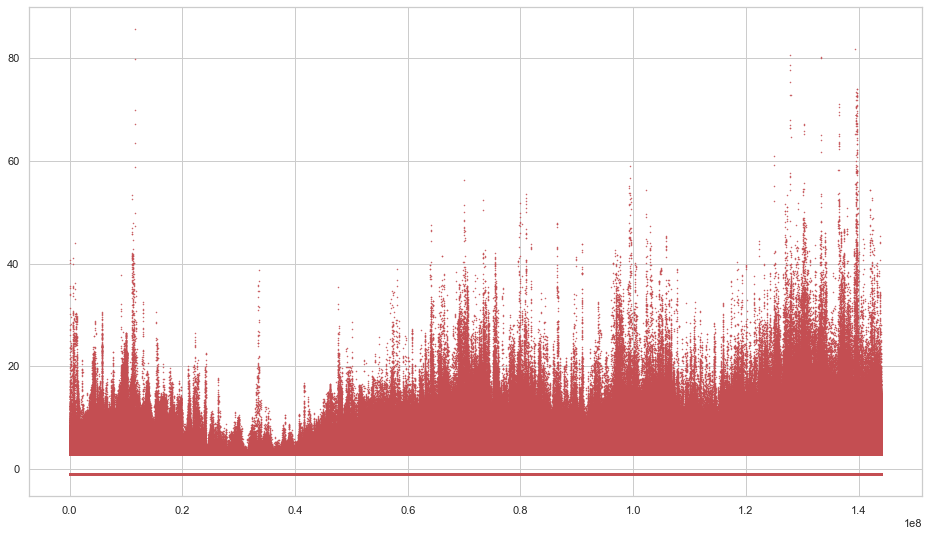

In [16]:
spotpy.analyser.plot_parameter_uncertainty(results, evaluation=get_ready.evaluation())

The figure as been saved as "Parameter_trace.png


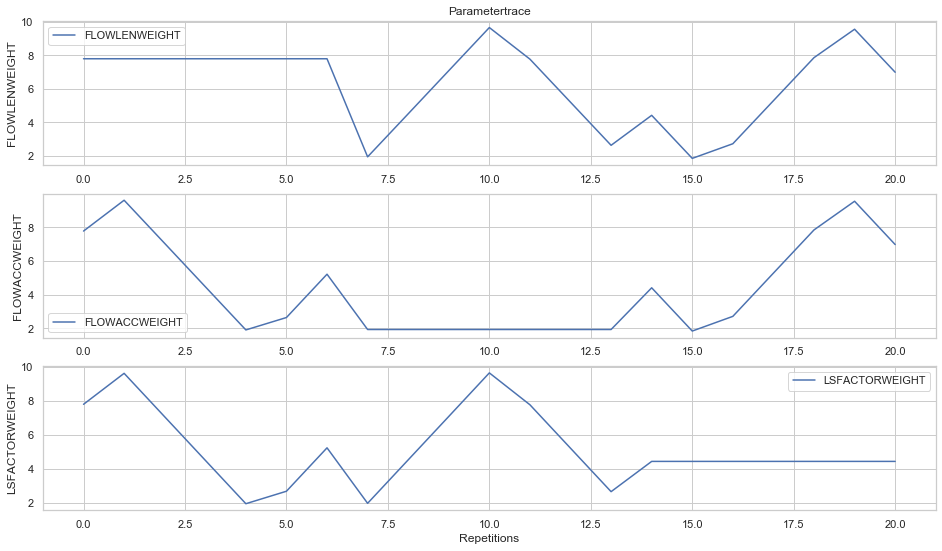

In [17]:
spotpy.analyser.plot_parametertrace(results)

The figure as been saved as "FAST_sensitivity_parameter_trace_zone_21.png
('Number of model runs:', 579)
('Number of parameters:', 3)
('m =', 3)
('Omega =', array([24.,  1.,  3.]))
Parameter First Total
{'S1': [None, None, None], 'ST': [None, None, None]}
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 1

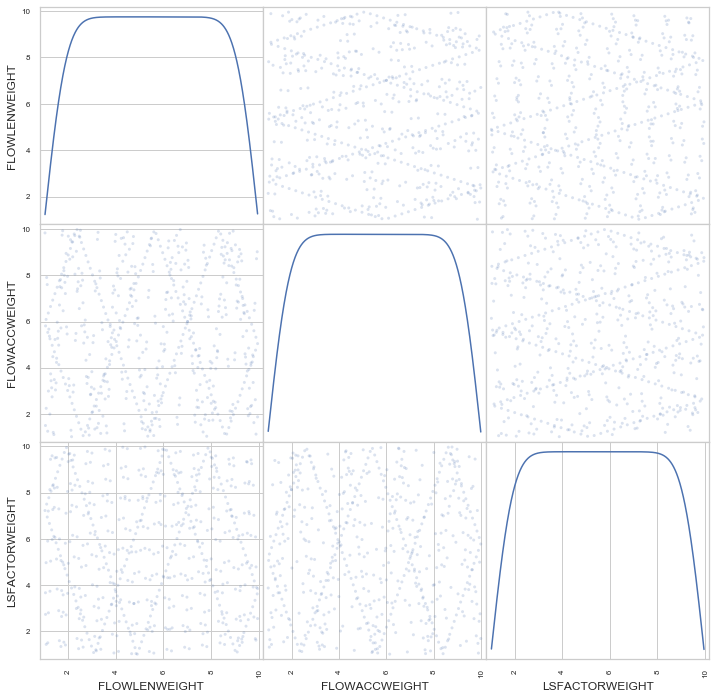

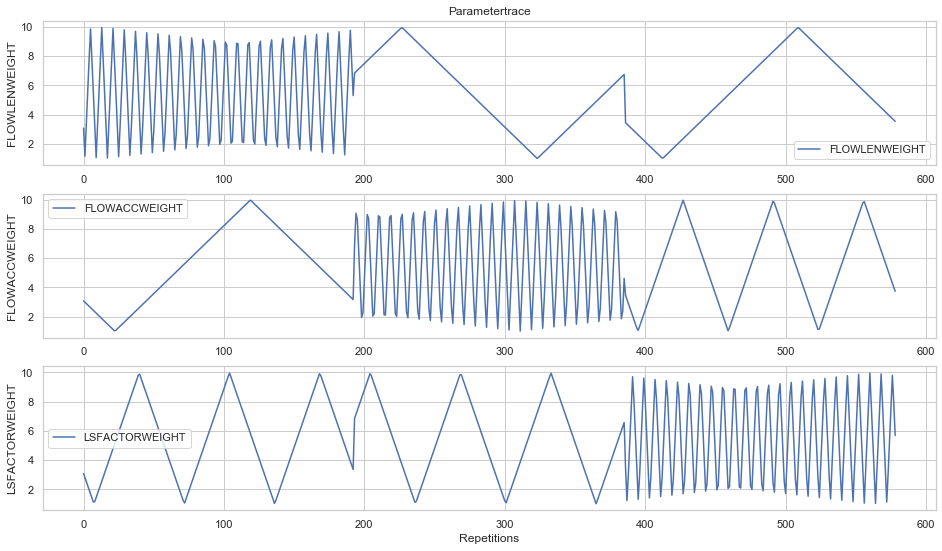

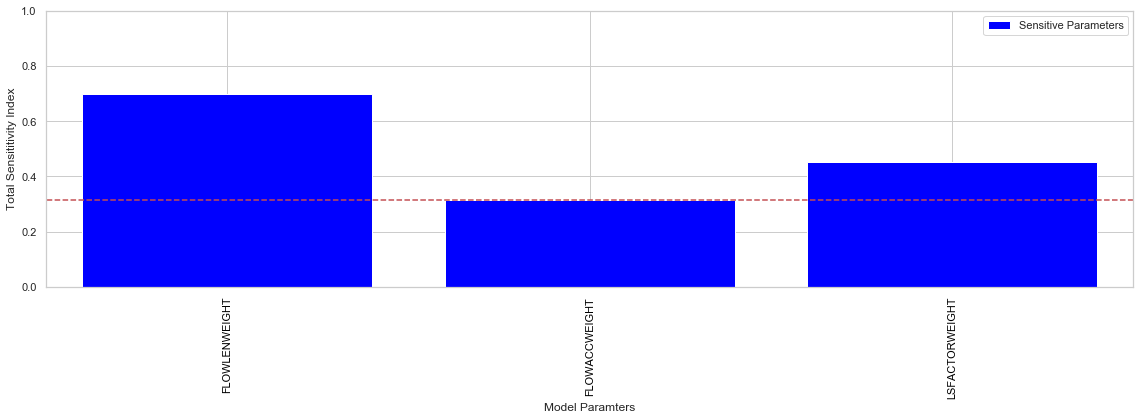

In [2]:
import spotpy

results = spotpy.analyser.load_csv_results('nomo_fast_sens_zone_21')
# results = load_csv_parameter_results('nomo_sens..')
spotpy.analyser.plot_parameterInteraction(results)
spotpy.analyser.plot_parametertrace(results, fig_name='FAST_sensitivity_parameter_trace_zone_21.png')
spotpy.analyser.plot_fast_sensitivity(results,number_of_sensitiv_pars=3, fig_name='FAST_sensitivity_zone_21.png')
# spotpy.analyser.plot_fast_sensitivity(results,like_index=1,number_of_sensitiv_pars=10,fig_name='FAST_sensitivity.png')
# plot_autocorellation(parameterdistribution,parametername,fig_name='Autocorrelation.png')


*** Final SPOTPY summary ***
Total Duration: 47295.28 seconds
Total Repetitions: 579
Minimal objective value: 0.754181
Corresponding parameter setting:
FLOWLENWEIGHT: 8.55907
FLOWACCWEIGHT: 1.1511
LSFACTORWEIGHT: 1.43963
Maximal objective value: 1
Corresponding parameter setting:
FLOWLENWEIGHT: 3.46373
FLOWACCWEIGHT: 3.4574
LSFACTORWEIGHT: 3.46193
******************************



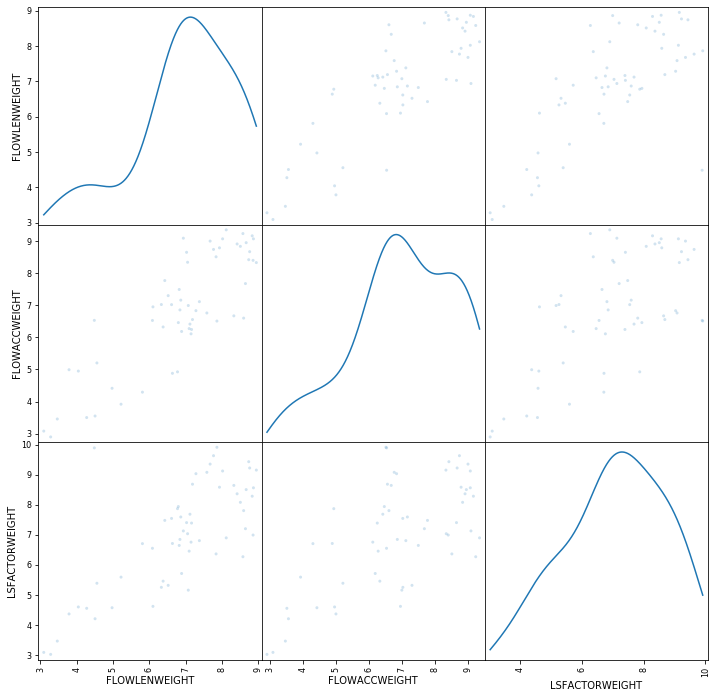

In [11]:
print("""
*** Final SPOTPY summary ***
Total Duration: 47295.28 seconds
Total Repetitions: 579
Minimal objective value: 0.754181
Corresponding parameter setting:
FLOWLENWEIGHT: 8.55907
FLOWACCWEIGHT: 1.1511
LSFACTORWEIGHT: 1.43963
Maximal objective value: 1
Corresponding parameter setting:
FLOWLENWEIGHT: 3.46373
FLOWACCWEIGHT: 3.4574
LSFACTORWEIGHT: 3.46193
******************************
""")
posterior=spotpy.analyser.get_posterior(results, percentage=10)
spotpy.analyser.plot_parameterInteraction(posterior)

The figure as been saved as "Parameter_trace.png
('Number of model runs:', 579)
('Number of parameters:', 3)
('m =', 3)
('Omega =', array([24.,  1.,  3.]))
Parameter First Total
{'S1': [None, None, None], 'ST': [None, None, None]}
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 18

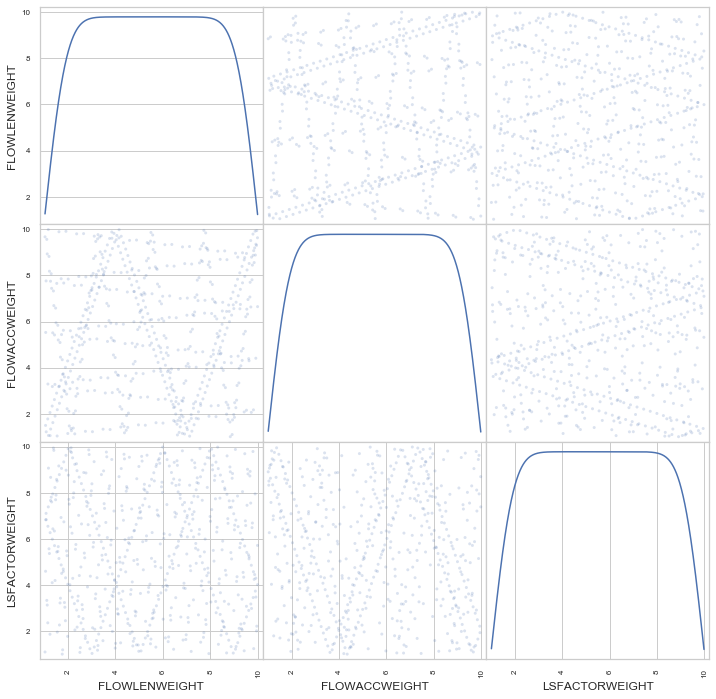

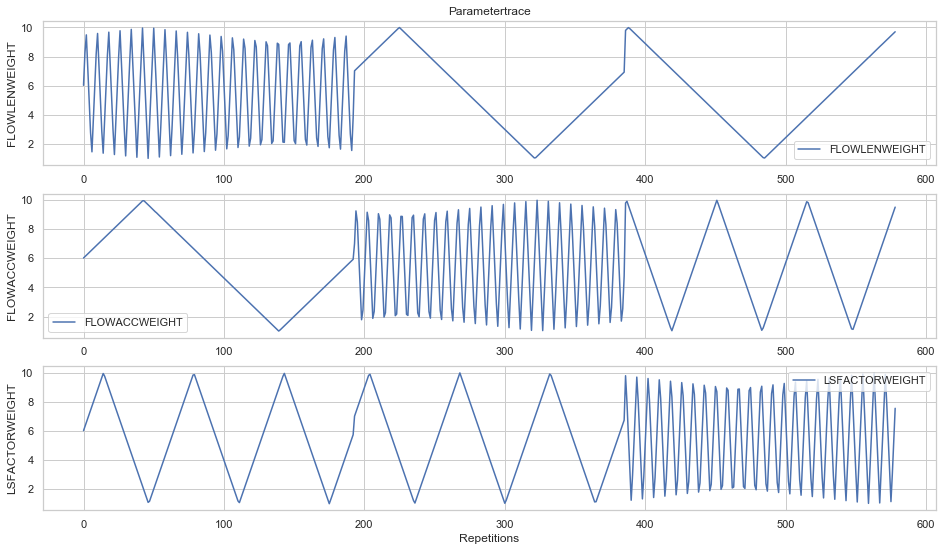

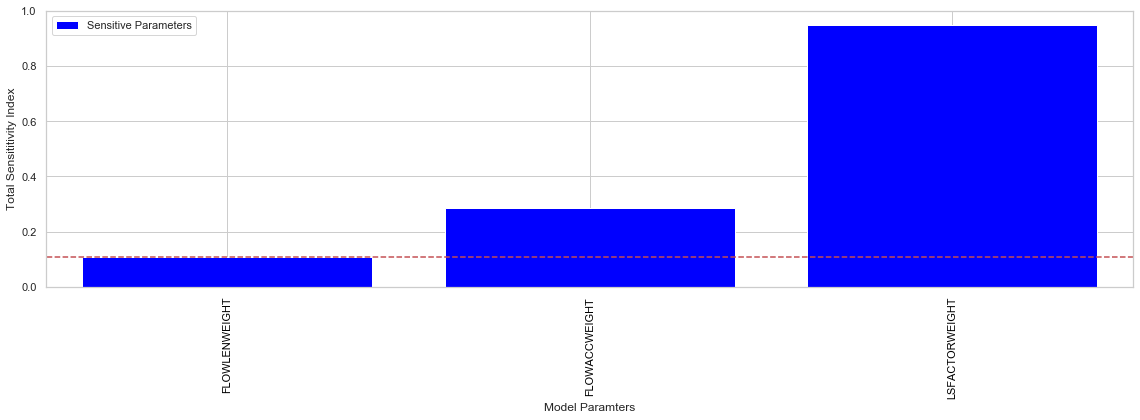

In [133]:
import spotpy

results = spotpy.analyser.load_csv_results('nomo_fast_sens_zone_7')
# results = load_csv_parameter_results('nomo_sens..')
spotpy.analyser.plot_parameterInteraction(results)
spotpy.analyser.plot_parametertrace(results, fig_name='FAST_sensitivity_parameter_trace_zone_7.png')
spotpy.analyser.plot_fast_sensitivity(results,number_of_sensitiv_pars=3, fig_name='FAST_sensitivity_zone_.png')
# spotpy.analyser.plot_fast_sensitivity(results,like_index=1,number_of_sensitiv_pars=10,fig_name='FAST_sensitivity.png')
# plot_autocorellation(parameterdistribution,parametername,fig_name='Autocorrelation.png')

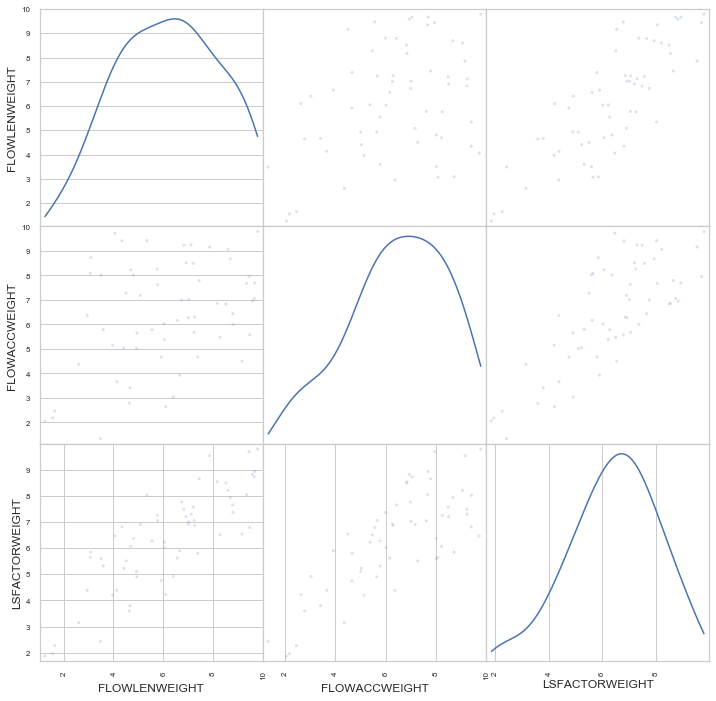

In [62]:
posterior=spotpy.analyser.get_posterior(results, percentage=10)
spotpy.analyser.plot_parameterInteraction(posterior)

In [114]:
import pandas as pd

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)

In [127]:
df_goog = pd.read_csv('nomo_uncert_nomo_uncert_lhs_zone_21.csv')
corr_cols_goog = []

with open('nomo_uncert_observed_index_21_corr_df_flattened_columns.txt', 'r') as fh:
    for line in fh.readlines():
        corr_cols_goog.append(line.strip().replace('\n',''))

err_cols_goog = []
with open('nomo_uncert_observed_index_21_error_metrics_columns.txt', 'r') as fh:
    for line in fh.readlines():
        err_cols_goog.append(line.strip())

all_cols_goog = corr_cols_goog + err_cols_goog
len(all_cols_goog)

for num in range(0, len(all_cols_goog)):
    df_goog = df_goog.rename(columns={ f"simulation_{num}" : all_cols_goog[num]})

    drop_cols_goog = ['like1', 'dstat_buf_count', 'dstat_buf_err_count', 'dstat_slopelen_count' ,'dstat_slopelen_err_count' ,'covariance_slopelen', 'mse_slopelen', 'chain']
    
df_goog = df_goog.drop(columns=drop_cols_goog)
df_goog

parFLOWLENWEIGHT  parFLOWACCWEIGHT  parLSFACTORWEIGHT  \
0               8.555             6.055              4.490   
1               1.130             7.387              7.547   
2               3.988             2.088              8.664   
3               1.405             9.766              6.440   
4               6.945             2.480              6.555   
..                ...               ...                ...   
201             5.850             8.375              2.610   
202             1.612             7.055              3.645   
203             8.766             9.430              6.030   
204             6.790             1.140              8.695   
205             2.140             5.953              5.766   

     corr__slope__slope  corr__slope__grass_flowlen  \
0                   1.0                      0.1683   
1                   1.0                      0.1683   
2                   1.0                      0.1683   
3                   1.0                      0.1683   
4                   1.0                      0.1683   
..                  ...                         ...   
201                 1.0                      0.1683   
202                 1.0                      0.1683   
203                 1.0                      0.1683   
204                 1.0                      0.1683   
205                 1.0                      0.1683   

     corr__slope__grass_flowacc  corr__slope__lsfactor  \
0                      0.003683                 0.6963   
1                      0.003683                 0.6963   
2                      0.003683                 0.6963   
3                      0.003683                 0.6963   
4                      0.003683                 0.6963   
..                          ...                    ...   
201                    0.003683                 0.6963   
202                    0.003683                 0.6963   
203                    0.003683                 0.6963   
204                    0.003683                 0.6963   
205                    0.003683                 0.6963   

     corr__slope__soil_class  corr__slope__calc_slopelen  \
0                     0.1874                      0.2418   
1                     0.1874                      0.5940   
2                     0.1874                      0.4220   
3                     0.1874                      0.5312   
4                     0.1874                      0.2966   
..                       ...                         ...   
201                   0.1874                      0.2292   
202                   0.1874                      0.4124   
203                   0.1874                      0.2625   
204                   0.1874                      0.3367   
205                   0.1874                      0.4530   

     corr__slope__buffer_width  corr__grass_flowlen__slope  \
0                       0.3887                      0.1683   
1                       0.3955                      0.1683   
2                       0.4805                      0.1683   
3                       0.3677                      0.1683   
4                       0.4560                      0.1683   
..                         ...                         ...   
201                     0.3318                      0.1683   
202                     0.3650                      0.1683   
203                     0.3904                      0.1683   
204                     0.4836                      0.1683   
205                     0.4146                      0.1683   

     corr__grass_flowlen__grass_flowlen  corr__grass_flowlen__grass_flowacc  \
0                                   1.0                              0.2155   
1                                   1.0                              0.2155   
2                                   1.0                              0.2155   
3                                   1.0                              0.2155   
4                                   1.0  

In [132]:
stat_df_goog = df_goog.describe(percentiles=[.05, .1, .2, .3,.4 ,.5, .6, .7, .8, .9, .95])
display(stat_df_goog.drop(columns=corr_cols_goog).T.drop(columns=['count']).head(100))

mean          std          min  \
parFLOWLENWEIGHT                       5.459279     2.594239     1.010000   
parFLOWACCWEIGHT                       5.724432     2.606051     1.020000   
parLSFACTORWEIGHT                      5.341354     2.643662     1.020000   
dstat_buf_mean                         3.117388     0.067268     3.014000   
dstat_buf_std                          0.817432     0.254195     0.236800   
dstat_buf_min                          3.000000     0.000000     3.000000   
dstat_buf_5%                           3.000000     0.000000     3.000000   
dstat_buf_10%                          3.000000     0.000000     3.000000   
dstat_buf_20%                          3.000000     0.000000     3.000000   
dstat_buf_30%                          3.000000     0.000000     3.000000   
dstat_buf_40%                          3.000000     0.000000     3.000000   
dstat_buf_50%                          3.000000     0.000000     3.000000   
dstat_buf_60%                          3.000000     0.000000     3.000000   
dstat_buf_70%                          3.000000     0.000000     3.000000   
dstat_buf_80%                          3.000000     0.000000     3.000000   
dstat_buf_90%                          3.009204     0.051981     3.000000   
dstat_buf_95%                          3.307845     0.507720     3.000000   
dstat_buf_max                         88.543447    25.937726    43.800000   
dstat_slopelen_mean                  256.151893    88.636308    89.100000   
dstat_slopelen_std                   356.931068   124.111437   132.200000   
dstat_slopelen_min                     0.000000     0.000000     0.000000   
dstat_slopelen_5%                      0.000000     0.000000     0.000000   
dstat_slopelen_10%                    25.163519    10.462484     5.727000   
dstat_slopelen_20%                    34.625917    11.689650    11.240000   
dstat_slopelen_30%                    57.711650    20.968281    17.890000   
dstat_slopelen_40%                    84.420000    30.348321    26.970000   
dstat_slopelen_50%                   122.768981    43.161907    40.000000   
dstat_slopelen_60%                   182.054466    63.338195    59.720000   
dstat_slopelen_70%                   269.671117    92.658206    89.940000   
dstat_slopelen_80%                   403.240777   137.504473   137.400000   
dstat_slopelen_90%                   651.815534   222.832642   227.000000   
dstat_slopelen_95%                   928.894660   320.326722   328.500000   
dstat_slopelen_max                 13157.398058  2304.911055  9336.000000   
dstat_buf_err_mean                    -0.011105     0.067198    -0.257000   
dstat_buf_err_std                      0.338711     0.183469     0.003336   
dstat_buf_err_min                    -19.106932    18.250860  -104.200000   
dstat_buf_err_5%                      -0.220146     0.419086    -2.033000   
dstat_buf_err_10%                     -0.006410     0.039446    -0.402800   
dstat_buf_err_20%                      0.000000     0.000000     0.000000   
dstat_buf_err_30%                      0.000000     0.000000     0.000000   
dstat_buf_err_40%                      0.000000     0.000000     0.000000   
dstat_buf_err_50%                      0.000000     0.000000     0.000000   
dstat_buf_err_60%                      0.000000     0.000000     0.000000   
dstat_buf_err_70%                      0.000000     0.000000     0.000000   
dstat_buf_err_80%                      0.000000     0.000000     0.000000   
dstat_buf_err_90%                      0.000000     0.000000     0.000000   
dstat_buf_err_95%                      0.000000     0.000000     0.000000   
dstat_buf_err_max                     21.048063    16.575978     0.152800   
dstat_slopelen_err_mean                2.748815    88.634027  -244.100000   
dstat_slopelen_err_std               113.058641    76.305865     1.631000   
dstat_slopelen_err_min             -2890.682087  1705.035419 -7960.000000   
dstat_slopelen_err_5%               -13

In [124]:
corr_cols_goog

['corr__slope__slope',
 'corr__slope__grass_flowlen',
 'corr__slope__grass_flowacc',
 'corr__slope__lsfactor',
 'corr__slope__soil_class',
 'corr__slope__calc_slopelen',
 'corr__slope__buffer_width',
 'corr__grass_flowlen__slope',
 'corr__grass_flowlen__grass_flowlen',
 'corr__grass_flowlen__grass_flowacc',
 'corr__grass_flowlen__lsfactor',
 'corr__grass_flowlen__soil_class',
 'corr__grass_flowlen__calc_slopelen',
 'corr__grass_flowlen__buffer_width',
 'corr__grass_flowacc__slope',
 'corr__grass_flowacc__grass_flowlen',
 'corr__grass_flowacc__grass_flowacc',
 'corr__grass_flowacc__lsfactor',
 'corr__grass_flowacc__soil_class',
 'corr__grass_flowacc__calc_slopelen',
 'corr__grass_flowacc__buffer_width',
 'corr__lsfactor__slope',
 'corr__lsfactor__grass_flowlen',
 'corr__lsfactor__grass_flowacc',
 'corr__lsfactor__lsfactor',
 'corr__lsfactor__soil_class',
 'corr__lsfactor__calc_slopelen',
 'corr__lsfactor__buffer_width',
 'corr__soil_class__slope',
 'corr__soil_class__grass_flowlen',
 'c

In [65]:
df = pd.read_csv('nomo_uncert_lhs_zone_21.csv')
corr_cols = []

with open('observed_index_21_corr_df_flattened_columns.txt', 'r') as fh:
    for line in fh.readlines():
        corr_cols.append(line.strip())


for num in range(0, len(corr_cols)):
    df = df.rename(columns={ f"simulation_{num}" : all_cols[num]})

df

like1  parFLOWLENWEIGHT  parFLOWACCWEIGHT  parLSFACTORWEIGHT  \
0    0.9663            5.8400             6.844              2.037   
1    0.9927            5.7660             8.560              3.783   
2    0.9404            3.3850             9.360              9.770   
3    0.9770            4.9800             1.565              2.666   
4    0.9453            1.1875             1.005              3.375   
..      ...               ...               ...                ...   
574  0.9976            3.5500             5.637              3.824   
575  0.9565            1.5440             5.395              3.432   
576  0.9507            8.3500             1.630              2.715   
577  0.9326            3.1270             3.730              9.945   
578  0.9536            7.4140             4.527              2.152   

     corr__slope__slope  corr__slope__grass_flowlen  \
0                   1.0                      0.1683   
1                   1.0                      0.1683   
2                   1.0                      0.1683   
3                   1.0                      0.1683   
4                   1.0                      0.1683   
..                  ...                         ...   
574                 1.0                      0.1683   
575                 1.0                      0.1683   
576                 1.0                      0.1683   
577                 1.0                      0.1683   
578                 1.0                      0.1683   

     corr__slope__grass_flowacc  corr__slope__lsfactor  \
0                      0.003683                 0.6963   
1                      0.003683                 0.6963   
2                      0.003683                 0.6963   
3                      0.003683                 0.6963   
4                      0.003683                 0.6963   
..                          ...                    ...   
574                    0.003683                 0.6963   
575                    0.003683                 0.6963   
576                    0.003683                 0.6963   
577                    0.003683                 0.6963   
578                    0.003683                 0.6963   

     corr__slope__soil_class  corr__slope__calc_slopelen  \
0                     0.1874                      0.2166   
1                     0.1874                      0.2570   
2                     0.1874                      0.4663   
3                     0.1874                      0.2441   
4                     0.1874                      0.4712   
..                       ...                         ...   
574                   0.1874                      0.3086   
575                   0.1874                      0.4136   
576                   0.1874                      0.2155   
577                   0.1874                      0.4912   
578                   0.1874                      0.2096   

     corr__slope__buffer_width  corr__grass_flowlen__slope  \
0                       0.3280                      0.1683   
1                       0.3643                      0.1683   
2                       0.4177                      0.1683   
3                       0.4163                      0.1683   
4                       0.4707                      0.1683   
..                         ...                         ...   
574                     0.4040                      0.1683   
575                     0.3862                      0.1683   
576                     0.3918                      0.1683   
577                     0.4610                      0.1683   
578                     0.3535                      0.1683   

     corr__grass_flowlen__grass_flowlen  corr__grass_flowlen__grass_flowacc  \
0                                   1.0                              0.2155   
1                                   1.0                              0.2155   
2                                   1.0                              0.2155   
3                        

The figure as been saved as "Parameter_trace.png


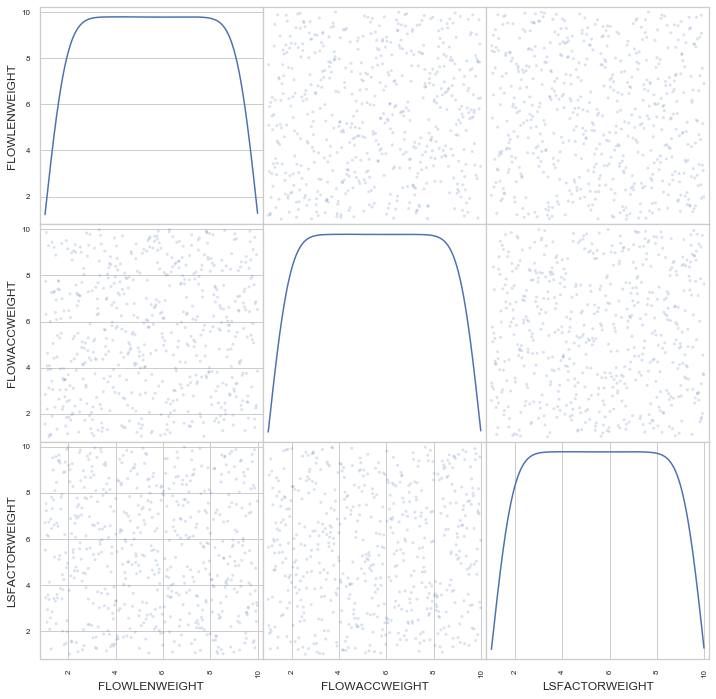

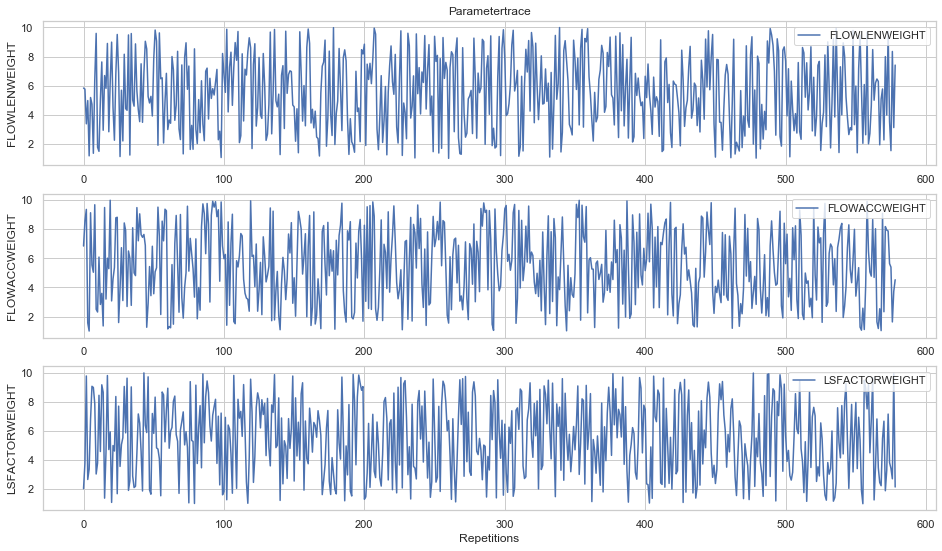

In [66]:
results = spotpy.analyser.load_csv_results('nomo_uncert_lhs_zone_21')
# results = load_csv_parameter_results('nomo_sens..')
spotpy.analyser.plot_parameterInteraction(results)
spotpy.analyser.plot_parametertrace(results)
# spotpy.analyser.plot_fast_sensitivity(results,number_of_sensitiv_pars=3)
# spotpy.analyser.plot_fast_sensitivity(results,like_index=1,number_of_sensitiv_pars=10,fig_name='FAST_sensitivity.png')
# plot_autocorellation(parameterdistribution,parametername,fig_name='Autocorrelation.png')

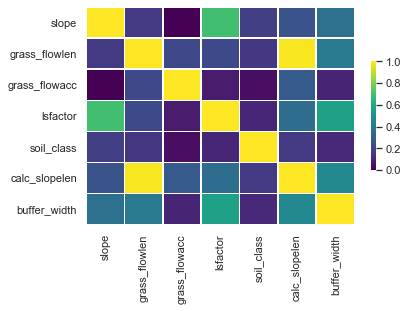

In [67]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

par_cols = ['parFLOWLENWEIGHT','parFLOWACCWEIGHT','parLSFACTORWEIGHT']

recorr = df.loc[1][corr_cols].values.reshape(7, 7)

corr_df = pd.DataFrame(recorr)

reduce_col = list(map(lambda x: x.split('__')[2], corr_cols[0:7]))

for i in range(0,7):
    corr_df = corr_df.rename(columns={i : reduce_col[i]})

for i in range(0,7):
    corr_df = corr_df.rename(index={i : reduce_col[i]})
    
sns.heatmap(corr_df, cmap='viridis', vmin=0, vmax=1, linewidths=.5, cbar_kws={"shrink": .5})

In [98]:
def get_full_corr_df(data_row):
    recorr = data_row[corr_cols].values.reshape(7, 7)

    corr_df = pd.DataFrame(recorr)

    reduce_col = list(map(lambda x: x.split('__')[2], corr_cols[0:7]))

    for i in range(0,7):
        corr_df = corr_df.rename(columns={i : reduce_col[i]})

    for i in range(0,7):
        corr_df = corr_df.rename(index={i : reduce_col[i]})
    
    return corr_df


In [69]:
# we want a dataframe
corr_eleven = [
 'corr__slope__calc_slopelen',
 'corr__slope__buffer_width',
 
 'corr__grass_flowlen__calc_slopelen',
 'corr__grass_flowlen__buffer_width',
 
 'corr__grass_flowacc__calc_slopelen',
 'corr__grass_flowacc__buffer_width',
 
 'corr__lsfactor__calc_slopelen',
 'corr__lsfactor__buffer_width',
 
 'corr__soil_class__calc_slopelen',
 'corr__soil_class__buffer_width',
 
 'corr__calc_slopelen__buffer_width'
 ]
red_df = df[['like1', 'parFLOWLENWEIGHT','parFLOWACCWEIGHT','parLSFACTORWEIGHT'] + corr_eleven].rename(columns={
                                                                    'like1' : 'r_squared',
                                                                    'parFLOWLENWEIGHT': 'FLOWLEN_WEIGHT',
                                                                    'parFLOWACCWEIGHT': 'FLOWACC_WEIGHT',
                                                                    'parLSFACTORWEIGHT': 'LSFACTOR_WEIGHT'})
red_df.sample(5)

r_squared  FLOWLEN_WEIGHT  FLOWACC_WEIGHT  LSFACTOR_WEIGHT  \
59      0.9990           6.850           9.266            7.438   
388     0.9720           2.408           5.496            1.111   
294     0.9710           1.819           6.457            1.404   
166     0.9673           2.477           2.084            5.566   
178     0.9575           9.984           6.523            3.111   

     corr__slope__calc_slopelen  corr__slope__buffer_width  \
59                       0.3105                     0.4153   
388                      0.2290                     0.2908   
294                      0.2646                     0.2913   
166                      0.4272                     0.4690   
178                      0.2125                     0.3547   

     corr__grass_flowlen__calc_slopelen  corr__grass_flowlen__buffer_width  \
59                               0.9736                             0.3235   
388                              0.9900                             0.3943   
294                              0.9760                             0.2590   
166                              0.9126                             0.2015   
178                              0.9970                             0.5670   

     corr__grass_flowacc__calc_slopelen  corr__grass_flowacc__buffer_width  \
59                               0.2703                            0.07715   
388                              0.3118                            0.12710   
294                              0.3577                            0.13180   
166                              0.2378                            0.04202   
178                              0.2450                            0.11000   

     corr__lsfactor__calc_slopelen  corr__lsfactor__buffer_width  \
59                          0.4290                        0.6733   
388                         0.3142                        0.4697   
294                         0.3696                        0.5273   
166                         0.5970                        0.7695   
178                         0.2852                        0.4870   

     corr__soil_class__calc_slopelen  corr__soil_class__buffer_width  \
59                            0.1724                         0.10724   
388                           0.1659                         0.09235   
294                           0.1682                         0.07010   
166                           0.1766                         0.09973   
178                           0.1647                         0.14800   

     corr__calc_slopelen__buffer_width  
59                              0.4512  
388                             0.4326  
294                             0.3394  
166                             0.4858  
178                             0.5900

In [95]:
stat_df = red_df.describe(percentiles=[.05, .1, .2, .3,.4 ,.5, .6, .7, .8, .9, .95])
stat_df.T

count      mean       std      min  \
r_squared                           579.0  0.969717  0.034541  0.82400   
FLOWLEN_WEIGHT                      579.0  5.504897  2.597236  1.01500   
FLOWACC_WEIGHT                      579.0  5.499904  2.600114  1.00500   
LSFACTOR_WEIGHT                     579.0  5.495092  2.597392  1.00500   
corr__slope__calc_slopelen          579.0  0.325209  0.102021  0.18540   
corr__slope__buffer_width           579.0  0.406865  0.047819  0.26500   
corr__grass_flowlen__calc_slopelen  579.0  0.949403  0.068657  0.65620   
corr__grass_flowlen__buffer_width   579.0  0.350806  0.159841  0.05045   
corr__grass_flowacc__calc_slopelen  579.0  0.260348  0.031431  0.19870   
corr__grass_flowacc__buffer_width   579.0  0.077243  0.027885  0.01823   
corr__lsfactor__calc_slopelen       579.0  0.450514  0.150060  0.24510   
corr__lsfactor__buffer_width        579.0  0.640361  0.102348  0.38620   
corr__soil_class__calc_slopelen     579.0  0.170550  0.004178  0.16140   
corr__soil_class__buffer_width      579.0  0.114917  0.027460  0.04953   
corr__calc_slopelen__buffer_width   579.0  0.505005  0.064321  0.30500   

                                          5%       10%      20%       30%  \
r_squared                           0.887970  0.928560  0.94970  0.963160   
FLOWLEN_WEIGHT                      1.471100  1.913200  2.81760  3.706000   
FLOWACC_WEIGHT                      1.461100  1.904400  2.80960  3.699400   
LSFACTOR_WEIGHT                     1.461100  1.903400  2.80760  3.696000   
corr__slope__calc_slopelen          0.203440  0.213900  0.23534  0.256240   
corr__slope__buffer_width           0.316210  0.336320  0.36260  0.386800   
corr__grass_flowlen__calc_slopelen  0.775260  0.862240  0.91976  0.952000   
corr__grass_flowlen__buffer_width   0.083024  0.110360  0.17300  0.259600   
corr__grass_flowacc__calc_slopelen  0.224870  0.227800  0.23400  0.242140   
corr__grass_flowacc__buffer_width   0.029345  0.036588  0.04944  0.061252   
corr__lsfactor__calc_slopelen       0.270900  0.287600  0.31840  0.348940   
corr__lsfactor__buffer_width        0.446270  0.480500  0.54310  0.590520   
corr__soil_class__calc_slopelen     0.163500  0.164700  0.16640  0.167800   
corr__soil_class__buffer_width      0.070460  0.075700  0.08906  0.098470   
corr__calc_slopelen__buffer_width   0.401720  0.421340  0.44718  0.471160   

                                        40%      50%      60%      70%  \
r_squared                           0.97276  0.98200  0.98886  0.99300   
FLOWLEN_WEIGHT                      4.60180  5.50000  6.40800  7.29880   
FLOWACC_WEIGHT                      4.59460  5.49600  6.40380  7.29540   
LSFACTOR_WEIGHT                     4.59080  5.49000  6.39900  7.28800   
corr__slope__calc_slopelen          0.27736  0.30250  0.32636  0.36024   
corr__slope__buffer_width           0.40400  0.41580  0.42674  0.43642   
corr__grass_flowlen__calc_slopelen  0.96806  0.97750  0.98400  0.99000   
corr__grass_flowlen__buffer_width   0.31344  0.37040  0.41370  0.45782   
corr__grass_flowacc__calc_slopelen  0.24766  0.25440  0.26160  0.27100   
corr__grass_flowacc__buffer_width   0.07100  0.07904  0.08726  0.09623   
corr__lsfactor__calc_slopelen       0.38160  0.41580  0.45094  0.50080   
corr__lsfactor__buffer_width        0.63576  0.66850  0.69268  0.71340   
corr__soil_class__calc_slopelen     0.16960  0.17100  0.17220  0.17370   
corr__soil_class__buffer_width      0.10630  0.11676  0.12468  0.13154   
corr__calc_slopelen__buffer_width   0.48890  0.50500  0.52140  0.53884   

                                        80%       90%      95%     max  
r_squared                           0.99600  0.998500  0.99950  1.0000  
FLOWLEN_WEIGHT                      8.19800  9.092000  9.54150  9.9900  
FLOWACC_WEIGHT                      8.19200  9.092000  9.54150  9.9900  
LSFACTOR_WEIGHT                     8.18200  9.086800  9.53200  9.9800  
corr__slope__calc_slopelen          0.40892  0.478200  0.54713  0.61

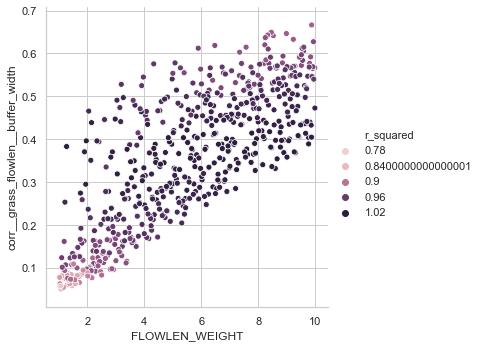

In [76]:
sns.relplot(x="FLOWLEN_WEIGHT", y="corr__grass_flowlen__buffer_width", hue="r_squared", data=red_df)

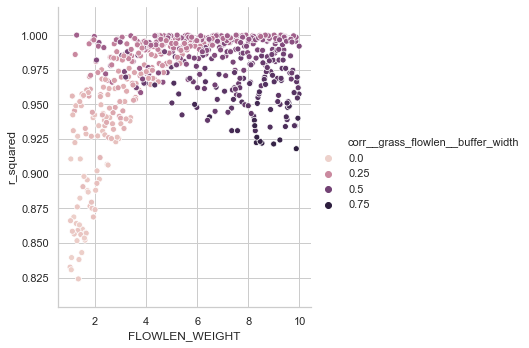

In [79]:
sns.relplot(x="FLOWLEN_WEIGHT", y="r_squared", hue="corr__grass_flowlen__buffer_width", data=red_df)

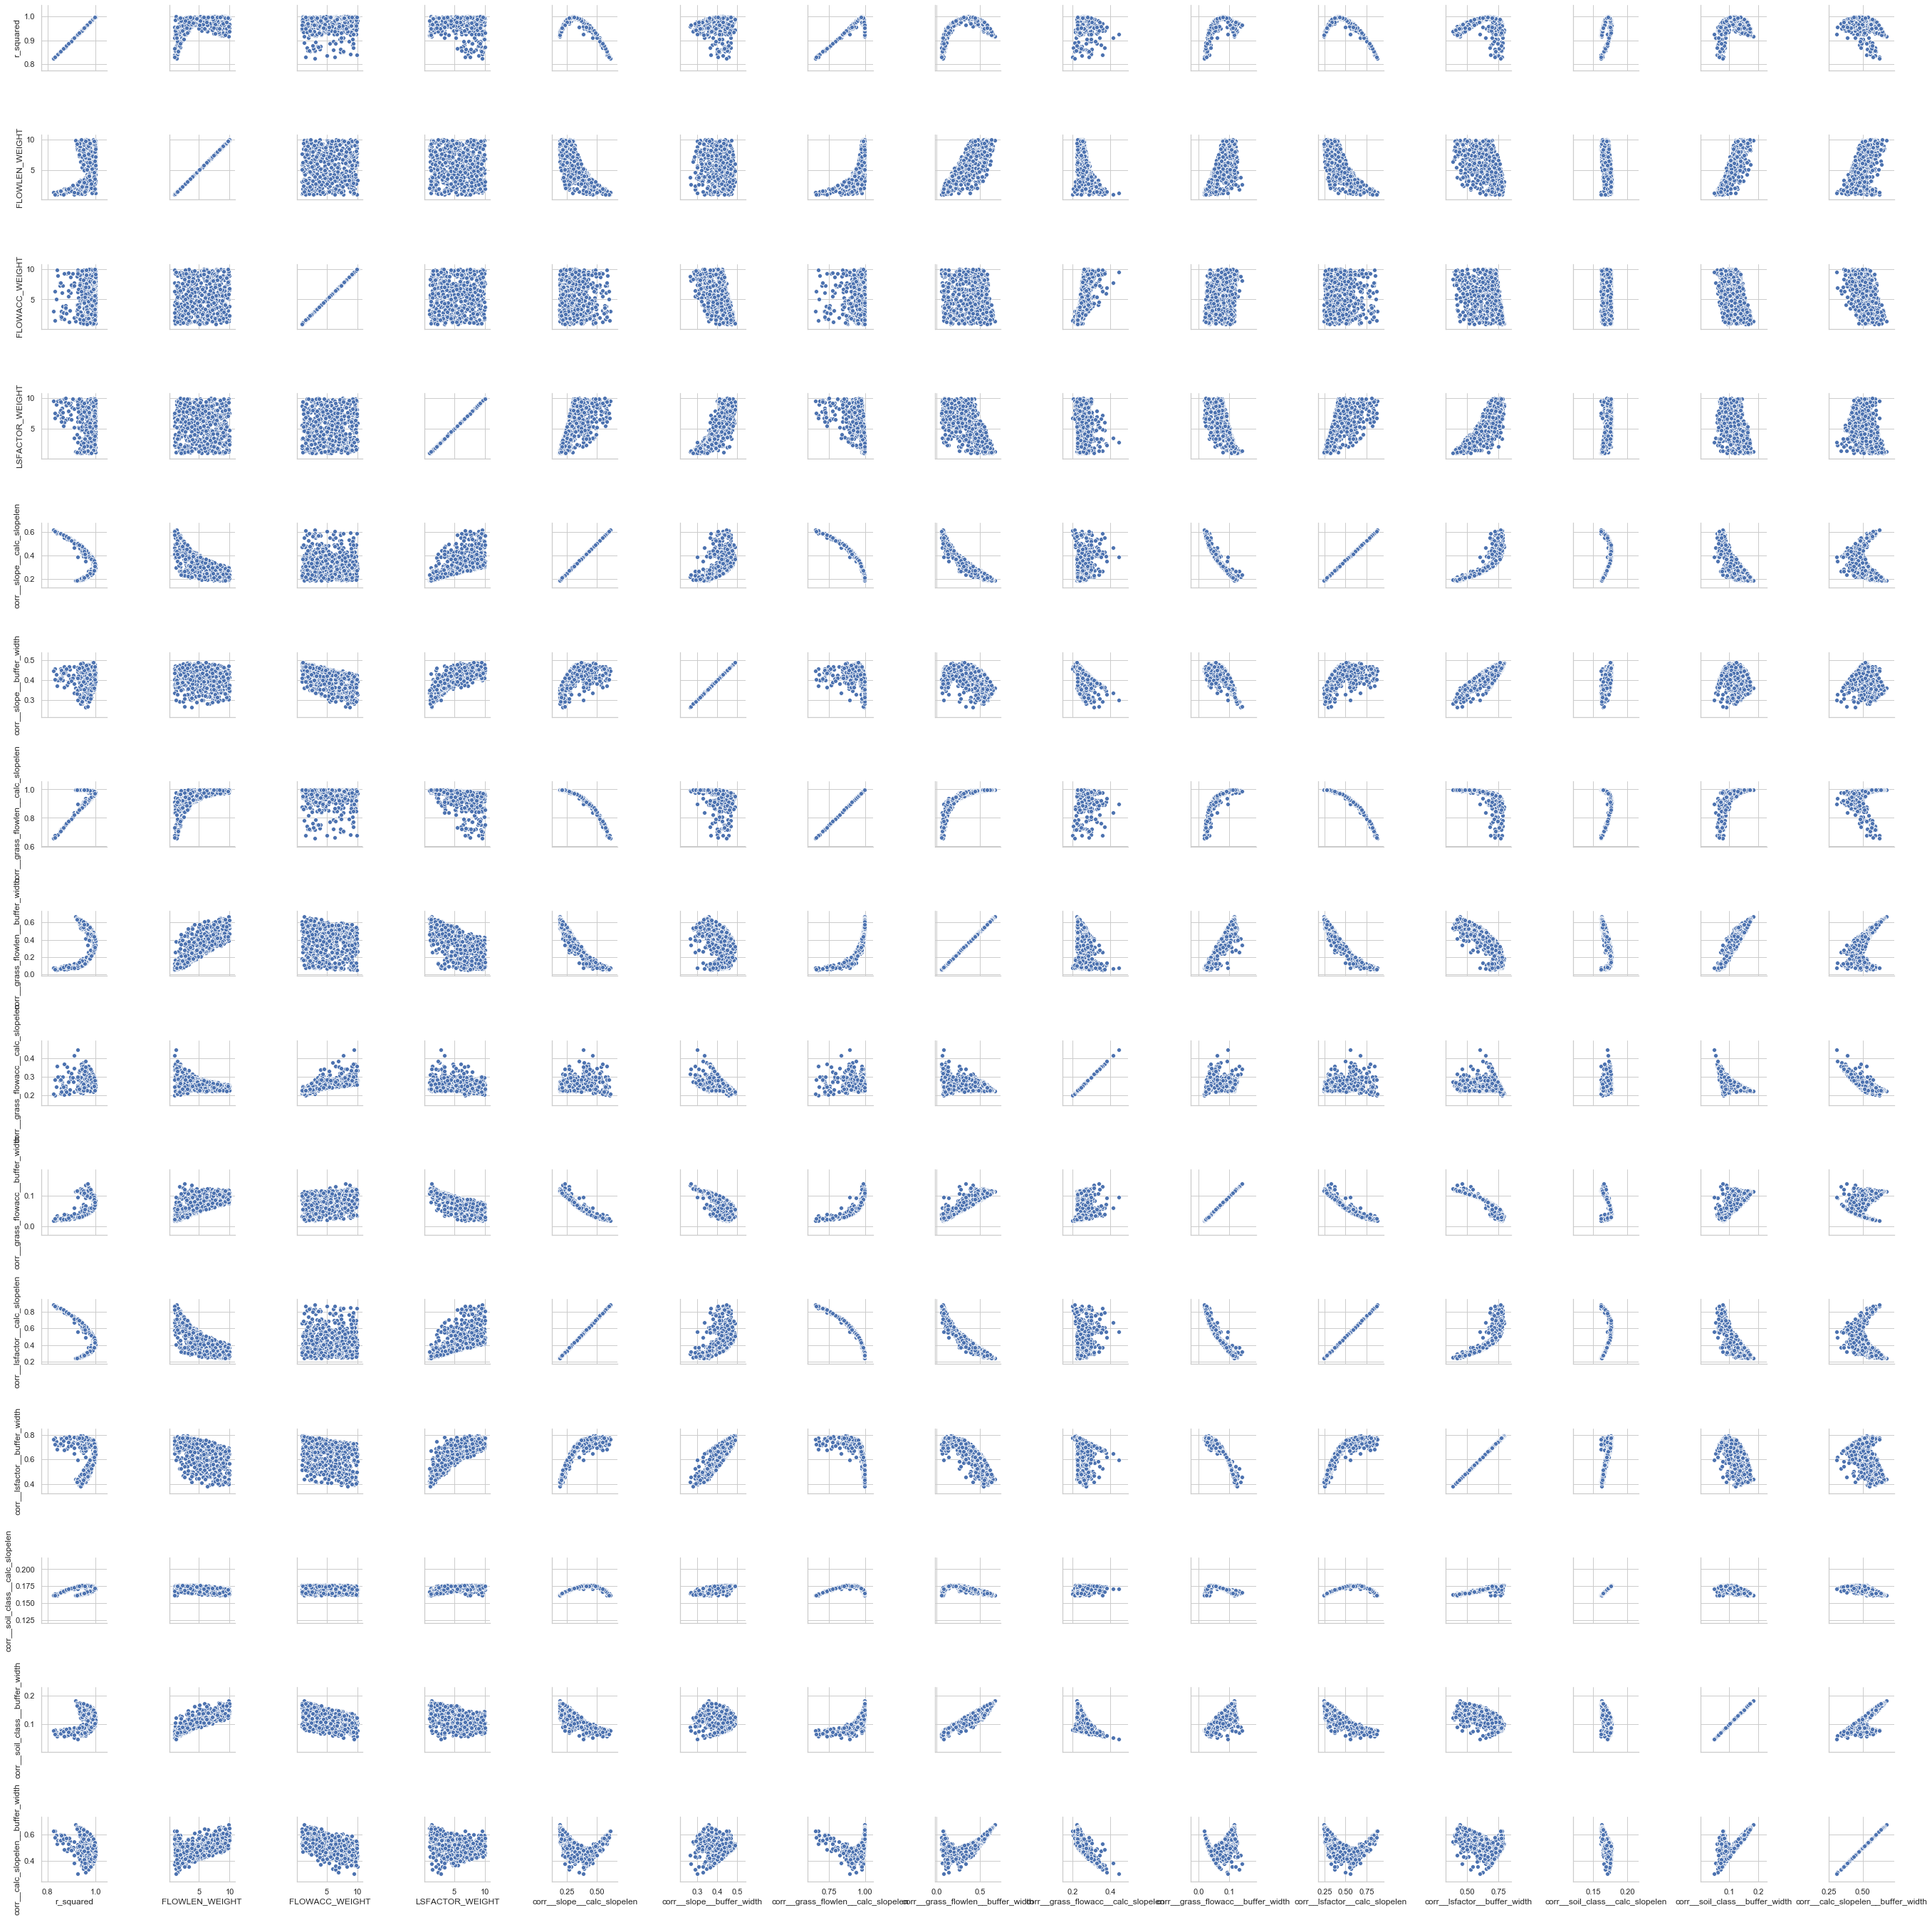

In [81]:
for corr_col in corr_eleven:
    g = sns.PairGrid(red_df)
    g.map(sns.scatterplot)

In [ ]:
for corr_col in corr_eleven:
    g = sns.PairGrid(red_df[['r_squared','FLOWLEN_WEIGHT','FLOWACC_WEIGHT','LSFACTOR_WEIGHT',corr_col]])
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=3, legend=False)
    g.fig.savefig(f"corr_kde_{corr_col}_weights.png", dpi=300)

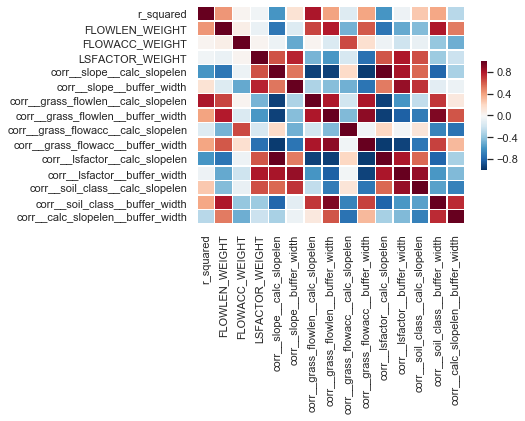

In [87]:
corr_corr_meta = red_df.corr()
sns.heatmap(corr_corr_meta, cmap='RdBu_r', vmin=-1, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .5})

count
mean


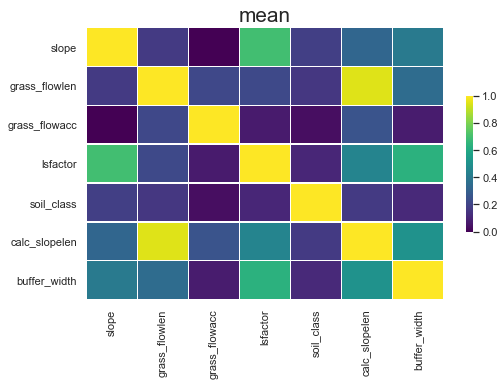

std


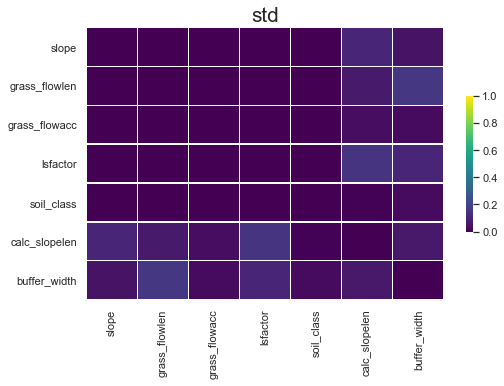

min


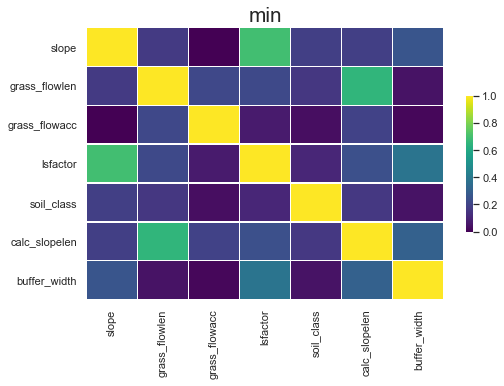

5%


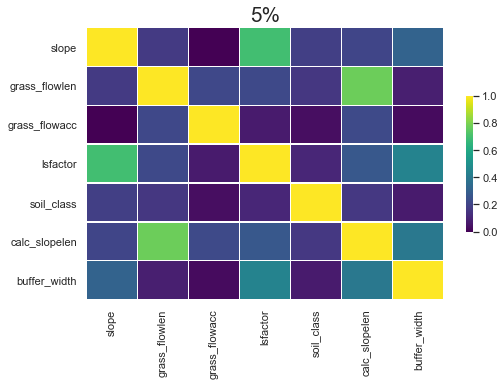

10%


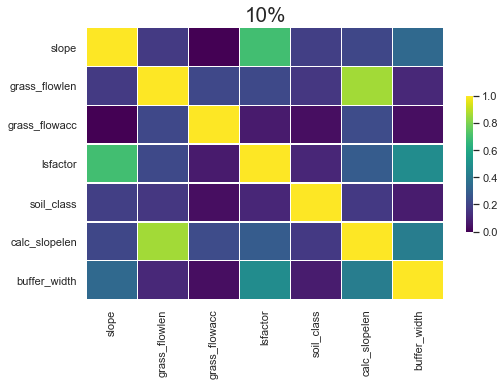

20%


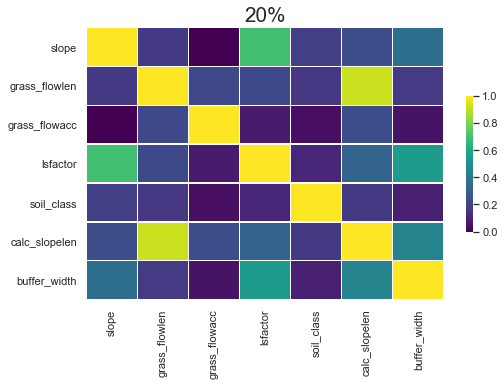

30%


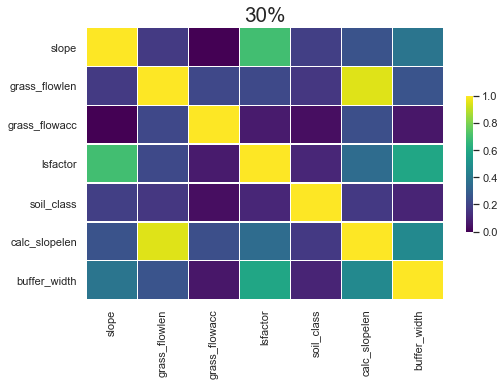

40%


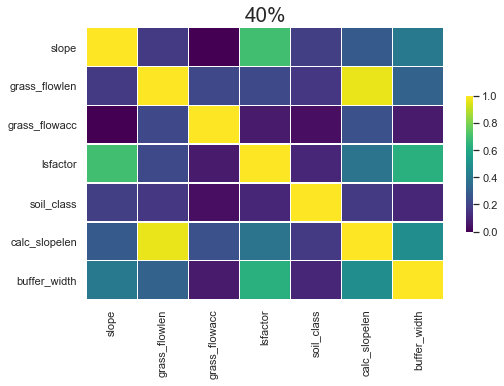

50%


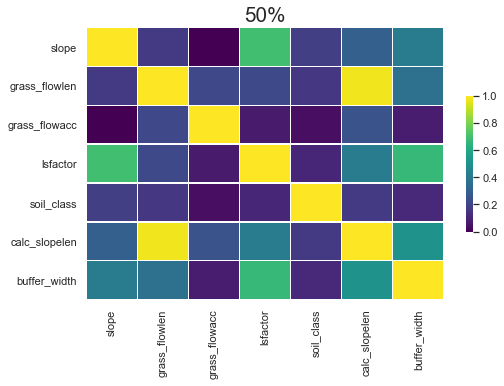

60%


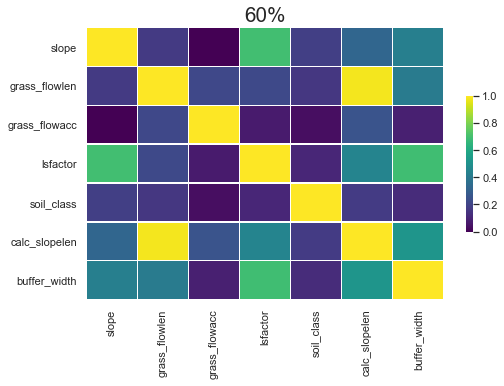

70%


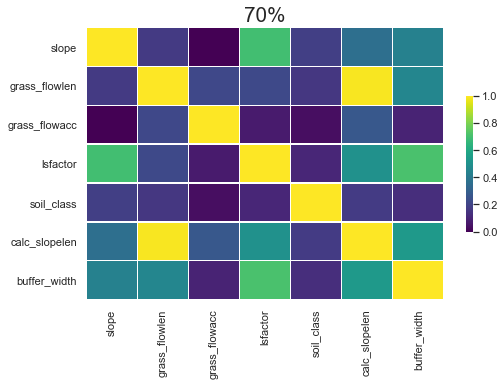

80%


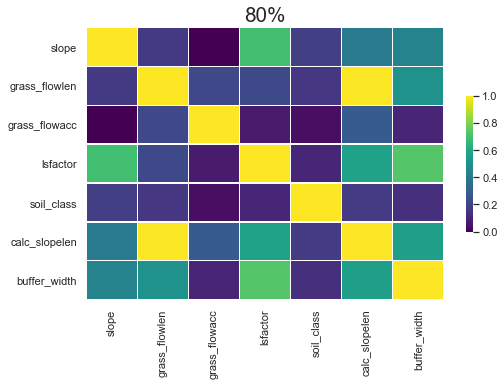

90%


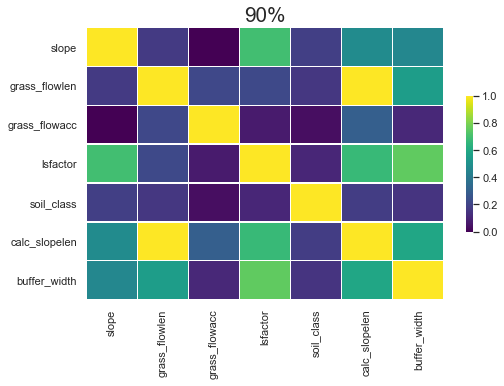

95%


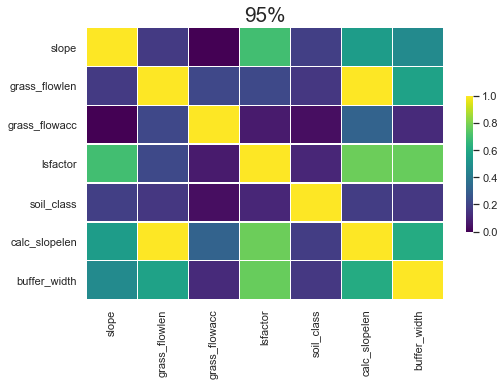

max


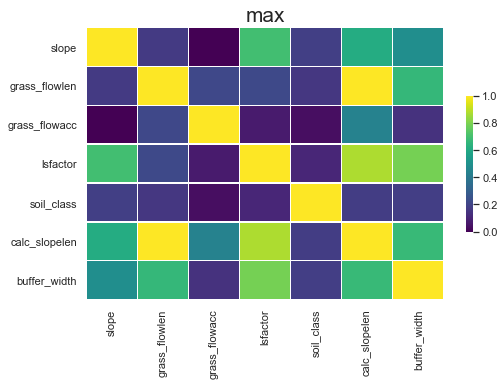

In [107]:
full_stat_df = df.describe(percentiles=[.05, .1, .2, .3,.4 ,.5, .6, .7, .8, .9, .95])

slices = []

for idx, data_row in full_stat_df.iterrows():
    print(idx)
    if not str(idx) in ['count']:
        fc = get_full_corr_df(data_row)
        slices.append(data_row)
        plt.figure(figsize=(8,5))
        g = sns.heatmap(fc, cmap='viridis', vmin=0, vmax=1, linewidths=.5, cbar_kws={"shrink": .5})
        plt.title(idx, fontsize='xx-large')
        plt.show()

In [177]:
import geopandas as gpd
import chardet


gdf = gpd.read_file('OneDrive_1_22-09-2020/loigatud_pollumassiivid_veekogumi_50m_puhvriga.shp')
gdf

taotlusaas  pollu_id  pindala_ha  \
0          2019  16126168        7.12   
1          2019  16308129       23.42   
2          2019  16308130        0.64   
3          2019  16308131       41.28   
4          2019  16308132        1.00   
...         ...       ...         ...   
3030       2019  17741453        1.96   
3031       2019  17741455        1.04   
3032       2019  17741457        2.09   
3033       2019  17741459        4.26   
3034       2019  17676599        0.19   

                                       taotletud_      taotletu_1 niitmise_t  \
0                            suvinisu allakklvita  P?llukultuurid       None   
1                            suvinisu allakllvita  P?llukultuurid       None   
2     k?rreliste rohumaa (vjhemalt 80% k?rrelisi)  P?llukultuurid       None   
3                            suviraps allakllvita  P?llukultuurid       None   
4     k?rreliste rohumaa (vjhemalt 80% k?rrelisi)  P?llukultuurid       None   
...                                           ...             ...        ...   
3030                                   rohttaimed     Posirohumaa       None   
3031                                   rohttaimed     Posirohumaa       None   
3032                                   rohttaimed     Posirohumaa       None   
3033                                   rohttaimed     Posirohumaa       None   
3034                                   rohttaimed     Posirohumaa       None   

     niitmise_1               viimase_mu  \
0          None  2019/06/16 16:50:06.000   
1          None  2019/05/15 15:48:53.000   
2          None  2019/05/15 15:48:53.000   
3          None  2019/05/15 15:48:53.000   
4          None  2019/05/15 15:48:53.000   
...         ...                      ...   
3030       None  2019/09/25 12:34:07.000   
3031       None  2019/09/25 12:34:07.000   
3032       None  2019/09/25 12:34:07.000   
3033       None  2019/09/25 12:34:07.000   
3034       None  2019/06/11 11:59:11.000   

                                             taotletu_2  tyki_S_ha  \
0     Keskkonnas?braliku majandamise toetus;Kliimat ...       0.20   
1     Keskkonnas?braliku majandamise toetus;Kliimat ...       2.31   
2     Keskkonnas?braliku majandamise toetus;Kliimat ...       0.64   
3     Keskkonnas?braliku majandamise toetus;Kliimat ...       3.33   
4     Keskkonnas?braliku majandamise toetus;Kliimat ...       1.00   
...                                                 ...        ...   
3030                                               None       1.54   
3031                                               None       1.04   
3032                                               None       1.52   
3033                                               None       3.03   
3034                                               None       0.08   

                                               geometry  
0     POLYGON ((533223.958 6488825.138, 533178.978 6...  
1     POLYGON ((546477.213 6437230.915, 546468.551 6...  
2     POLYGON ((546407.856 6437397.970, 546414.377 6...  
3     POLYGON ((546439.810 6437233.862, 546438.104 6...  
4     POLYGON ((546439.810 6437233.862, 546436.159 6...  
...                                                 ...  
3030  POLYGON ((452278.482 6538184.698, 452282.450 6...  
3031  POLYGON ((452282.459 6538185.144, 452282.450 6...  
3032  POLYGON ((452264.423 6538459.161, 452134.525 6...  
3033  POLYGON ((452300.501 6538597.571, 452257.441 6...  
3034  POLYGON ((449302.860 6477222.537, 449304.407 6...  

[3035 rows x 11 columns]

In [178]:
elems = []

for col in ['taotletud_', 'taotletu_1', 'taotletu_2']:
    for idx, row in gdf.iterrows():
        elems.append(str(row[col]).strip())
t = set(elems)
print(len(set(elems)))

131


In [179]:
updater = {  '?': 'õ',
    'v0hemalt': 'vähemalt' ,
    'vjhemalt': 'vähemalt' ,
    'vshemalt' : 'vähemalt' ,
    'vkhemalt' : 'vähemalt' ,
    'vohemalt' : 'vähemalt' ,
    'v:hemalt' : 'vähemalt' ,
           'vdhemalt' : 'vähemalt' ,
           
           'p si': 'püsi',
           'p6si': 'püsi',
           'p8si': 'püsi',
           'p9si': 'püsi',
           'pdsi': 'püsi',
           
           'Pasikultuurid': 'Püsikultuurid',
             'Pisikultuurid': 'Püsikultuurid',
             'Posirohumaa': 'Püsikultuurid',
             'Pssikultuurid': 'Püsikultuurid',
             'Pusikultuurid': 'Püsikultuurid',
           
           'ahtne': 'ühtne',
           'ihtne': 'ühtne',
           ';htne': 'ühtne',
           'Nhtne': 'ühtne',
           'Phtne': 'ühtne',
           'ehtne': 'ühtne',
           'mhtne' : 'ühtne',
           'thtne' : 'ühtne',
           'uhtne' : 'ühtne',
           
           's lstvate': 'säästvate',
           'shestvate': 'säästvate',
           'stnstvate ': 'säästvate',
           'sorstvate' : 'säästvate',
           'stustvate'  : 'säästvate',
           'ssvstvate'  : 'säästvate',
           's50stvate'  : 'säästvate',
           'sirstvate'  : 'säästvate',
           
           'allakklvi': 'allakülvi',
           'allakalvi': 'allakülvi',
           'allakllvi': 'allakülvi',
           'allak2lvi': 'allakülvi',
           'allak4lvi': 'allakülvi',
           'allakmlvi': 'allakülvi',
           'allak.lvi': 'allakülvi',
           'allakolvi': 'allakülvi',
           'allakõlvi': 'allakülvi',
           'allak lvi':  'allakülvi',
           'allak1lvi':  'allakülvi',
           
           'k00givil' : 'köögivil',
           'k01givil' : 'köögivil',
           'kdagivil' : 'köögivil',
           
           'v:lja' : 'välja',
           'valja': 'välja',
           'vslja': 'välja',
           
           's01ti': 'sööti',
           
           'j etud': 'jäetud',
           'jnetud': 'jäetud',
           
           'talirops': 'talirüps',
           
           'vsikestel': 'väikestel',
           'vkikestel': 'väikestel',
           
           ' sle ' : ' üle ',
           
           '0heaasta' : 'üheaasta',
           '2heaasta' : 'üheaasta',
           
           'sbrgipeet' :'söögipeet',
           
}

def find_and_change(text):
    temp = text
    for k, v in updater.items():
        temp = temp.replace(k, v)
    return temp

set(map(lambda x: find_and_change(x), t))

{'Karjatamine väljaspool põllumaj. maad',
 'Keskkonnasõbraliku köögivilja-, ravimtaime- ja maitsetaimekasvatuse ning maasikakasvatuse toetus;Keskkonnasõbraliku majandamise toetus;Kliimat ja keskkonda säästvatepõllumajandustavade toetus;Puu- ja klagivilja kasvatamise otsetoetus;',
 'Keskkonnasõbraliku köögivilja-, ravimtaime- ja maitsetaimekasvatuse ning maasikakasvatuse toetus;Keskkonnasõbraliku majandamise toetus;Kliimat ja keskkonda säästvatepõllumajandustavade toetus;Puu- ja köögivilja kasvatamise otsetoetus;',
 'Keskkonnasõbraliku köögivilja-, ravimtaime- ja maitsetaimekasvatuse ning maasikakasvatuse toetus;Keskkonnasõbraliku majandamise toetus;Kliimat ja keskkonda säästvatepõllumajandustavade toetus;ühtne pindalatoetus',
 'Keskkonnasõbraliku majandamise toetus;Kliimat ja keskkonda säästvate põllumajandustavade toetus;Natura 2000 alal asuva põllumajandusmaa kohta antav toetus;ühtne pindalatoetus',
 'Keskkonnasõbraliku majandamise toetus;Kliimat ja keskkonda säästvate põllumajandust

In [180]:

for k, v in updater.items():
    for col in ['taotletud_', 'taotletu_1', 'taotletu_2']:
        gdf[col] = gdf[col].apply(lambda x: str(x).strip().replace(k, v))

display(gdf)

taotlusaas  pollu_id  pindala_ha  \
0          2019  16126168        7.12   
1          2019  16308129       23.42   
2          2019  16308130        0.64   
3          2019  16308131       41.28   
4          2019  16308132        1.00   
...         ...       ...         ...   
3030       2019  17741453        1.96   
3031       2019  17741455        1.04   
3032       2019  17741457        2.09   
3033       2019  17741459        4.26   
3034       2019  17676599        0.19   

                                       taotletud_      taotletu_1 niitmise_t  \
0                            suvinisu allakülvita  Põllukultuurid       None   
1                            suvinisu allakülvita  Põllukultuurid       None   
2     kõrreliste rohumaa (vähemalt 80% kõrrelisi)  Põllukultuurid       None   
3                            suviraps allakülvita  Põllukultuurid       None   
4     kõrreliste rohumaa (vähemalt 80% kõrrelisi)  Põllukultuurid       None   
...                                           ...             ...        ...   
3030                                   rohttaimed   Püsikultuurid       None   
3031                                   rohttaimed   Püsikultuurid       None   
3032                                   rohttaimed   Püsikultuurid       None   
3033                                   rohttaimed   Püsikultuurid       None   
3034                                   rohttaimed   Püsikultuurid       None   

     niitmise_1               viimase_mu  \
0          None  2019/06/16 16:50:06.000   
1          None  2019/05/15 15:48:53.000   
2          None  2019/05/15 15:48:53.000   
3          None  2019/05/15 15:48:53.000   
4          None  2019/05/15 15:48:53.000   
...         ...                      ...   
3030       None  2019/09/25 12:34:07.000   
3031       None  2019/09/25 12:34:07.000   
3032       None  2019/09/25 12:34:07.000   
3033       None  2019/09/25 12:34:07.000   
3034       None  2019/06/11 11:59:11.000   

                                             taotletu_2  tyki_S_ha  \
0     Keskkonnasõbraliku majandamise toetus;Kliimat ...       0.20   
1     Keskkonnasõbraliku majandamise toetus;Kliimat ...       2.31   
2     Keskkonnasõbraliku majandamise toetus;Kliimat ...       0.64   
3     Keskkonnasõbraliku majandamise toetus;Kliimat ...       3.33   
4     Keskkonnasõbraliku majandamise toetus;Kliimat ...       1.00   
...                                                 ...        ...   
3030                                               None       1.54   
3031                                               None       1.04   
3032                                               None       1.52   
3033                                               None       3.03   
3034                                               None       0.08   

                                               geometry  
0     POLYGON ((533223.958 6488825.138, 533178.978 6...  
1     POLYGON ((546477.213 6437230.915, 546468.551 6...  
2     POLYGON ((546407.856 6437397.970, 546414.377 6...  
3     POLYGON ((546439.810 6437233.862, 546438.104 6...  
4     POLYGON ((546439.810 6437233.862, 546436.159 6...  
...                                                 ...  
3030  POLYGON ((452278.482 6538184.698, 452282.450 6...  
3031  POLYGON ((452282.459 6538185.144, 452282.450 6...  
3032  POLYGON ((452264.423 6538459.161, 452134.525 6...  
3033  POLYGON ((452300.501 6538597.571, 452257.441 6...  
3034  POLYGON ((449302.860 6477222.537, 449304.407 6...  

[3035 rows x 11 columns]

In [181]:
import fiona
gdf.crs = fiona.crs.from_epsg(3301)

In [182]:
gdf.to_crs(fiona.crs.from_epsg(4326))

taotlusaas  pollu_id  pindala_ha  \
0          2019  16126168        7.12   
1          2019  16308129       23.42   
2          2019  16308130        0.64   
3          2019  16308131       41.28   
4          2019  16308132        1.00   
...         ...       ...         ...   
3030       2019  17741453        1.96   
3031       2019  17741455        1.04   
3032       2019  17741457        2.09   
3033       2019  17741459        4.26   
3034       2019  17676599        0.19   

                                       taotletud_      taotletu_1 niitmise_t  \
0                            suvinisu allakülvita  Põllukultuurid       None   
1                            suvinisu allakülvita  Põllukultuurid       None   
2     kõrreliste rohumaa (vähemalt 80% kõrrelisi)  Põllukultuurid       None   
3                            suviraps allakülvita  Põllukultuurid       None   
4     kõrreliste rohumaa (vähemalt 80% kõrrelisi)  Põllukultuurid       None   
...                                           ...             ...        ...   
3030                                   rohttaimed   Püsikultuurid       None   
3031                                   rohttaimed   Püsikultuurid       None   
3032                                   rohttaimed   Püsikultuurid       None   
3033                                   rohttaimed   Püsikultuurid       None   
3034                                   rohttaimed   Püsikultuurid       None   

     niitmise_1               viimase_mu  \
0          None  2019/06/16 16:50:06.000   
1          None  2019/05/15 15:48:53.000   
2          None  2019/05/15 15:48:53.000   
3          None  2019/05/15 15:48:53.000   
4          None  2019/05/15 15:48:53.000   
...         ...                      ...   
3030       None  2019/09/25 12:34:07.000   
3031       None  2019/09/25 12:34:07.000   
3032       None  2019/09/25 12:34:07.000   
3033       None  2019/09/25 12:34:07.000   
3034       None  2019/06/11 11:59:11.000   

                                             taotletu_2  tyki_S_ha  \
0     Keskkonnasõbraliku majandamise toetus;Kliimat ...       0.20   
1     Keskkonnasõbraliku majandamise toetus;Kliimat ...       2.31   
2     Keskkonnasõbraliku majandamise toetus;Kliimat ...       0.64   
3     Keskkonnasõbraliku majandamise toetus;Kliimat ...       3.33   
4     Keskkonnasõbraliku majandamise toetus;Kliimat ...       1.00   
...                                                 ...        ...   
3030                                               None       1.54   
3031                                               None       1.04   
3032                                               None       1.52   
3033                                               None       3.03   
3034                                               None       0.08   

                                               geometry  
0     POLYGON ((24.57048 58.53825, 24.56971 58.53825...  
1     POLYGON ((24.78763 58.07383, 24.78749 58.07400...  
2     POLYGON ((24.78649 58.07534, 24.78660 58.07519...  
3     POLYGON ((24.78700 58.07386, 24.78697 58.07386...  
4     POLYGON ((24.78700 58.07386, 24.78694 58.07395...  
...                                                 ...  
3030  POLYGON ((23.17012 58.98001, 23.17019 58.98002...  
3031  POLYGON ((23.17019 58.98002, 23.17019 58.98002...  
3032  POLYGON ((23.16982 58.98248, 23.16758 58.98156...  
3033  POLYGON ((23.17041 58.98372, 23.16967 58.98336...  
3034  POLYGON ((23.13210 58.43240, 23.13212 58.43232...  

[3035 rows x 11 columns]

In [183]:
gdf

taotlusaas  pollu_id  pindala_ha  \
0          2019  16126168        7.12   
1          2019  16308129       23.42   
2          2019  16308130        0.64   
3          2019  16308131       41.28   
4          2019  16308132        1.00   
...         ...       ...         ...   
3030       2019  17741453        1.96   
3031       2019  17741455        1.04   
3032       2019  17741457        2.09   
3033       2019  17741459        4.26   
3034       2019  17676599        0.19   

                                       taotletud_      taotletu_1 niitmise_t  \
0                            suvinisu allakülvita  Põllukultuurid       None   
1                            suvinisu allakülvita  Põllukultuurid       None   
2     kõrreliste rohumaa (vähemalt 80% kõrrelisi)  Põllukultuurid       None   
3                            suviraps allakülvita  Põllukultuurid       None   
4     kõrreliste rohumaa (vähemalt 80% kõrrelisi)  Põllukultuurid       None   
...                                           ...             ...        ...   
3030                                   rohttaimed   Püsikultuurid       None   
3031                                   rohttaimed   Püsikultuurid       None   
3032                                   rohttaimed   Püsikultuurid       None   
3033                                   rohttaimed   Püsikultuurid       None   
3034                                   rohttaimed   Püsikultuurid       None   

     niitmise_1               viimase_mu  \
0          None  2019/06/16 16:50:06.000   
1          None  2019/05/15 15:48:53.000   
2          None  2019/05/15 15:48:53.000   
3          None  2019/05/15 15:48:53.000   
4          None  2019/05/15 15:48:53.000   
...         ...                      ...   
3030       None  2019/09/25 12:34:07.000   
3031       None  2019/09/25 12:34:07.000   
3032       None  2019/09/25 12:34:07.000   
3033       None  2019/09/25 12:34:07.000   
3034       None  2019/06/11 11:59:11.000   

                                             taotletu_2  tyki_S_ha  \
0     Keskkonnasõbraliku majandamise toetus;Kliimat ...       0.20   
1     Keskkonnasõbraliku majandamise toetus;Kliimat ...       2.31   
2     Keskkonnasõbraliku majandamise toetus;Kliimat ...       0.64   
3     Keskkonnasõbraliku majandamise toetus;Kliimat ...       3.33   
4     Keskkonnasõbraliku majandamise toetus;Kliimat ...       1.00   
...                                                 ...        ...   
3030                                               None       1.54   
3031                                               None       1.04   
3032                                               None       1.52   
3033                                               None       3.03   
3034                                               None       0.08   

                                               geometry  
0     POLYGON ((533223.958 6488825.138, 533178.978 6...  
1     POLYGON ((546477.213 6437230.915, 546468.551 6...  
2     POLYGON ((546407.856 6437397.970, 546414.377 6...  
3     POLYGON ((546439.810 6437233.862, 546438.104 6...  
4     POLYGON ((546439.810 6437233.862, 546436.159 6...  
...                                                 ...  
3030  POLYGON ((452278.482 6538184.698, 452282.450 6...  
3031  POLYGON ((452282.459 6538185.144, 452282.450 6...  
3032  POLYGON ((452264.423 6538459.161, 452134.525 6...  
3033  POLYGON ((452300.501 6538597.571, 452257.441 6...  
3034  POLYGON ((449302.860 6477222.537, 449304.407 6...  

[3035 rows x 11 columns]

In [184]:
gdf.to_file('OneDrive_1_22-09-2020/loigatud_pollumassiivid_veekogumi_50m_puhvriga_utf8.shp', encoding='utf-8')